In [1]:
using Pkg
# Pkg.activate(".")
using AxisKeys
using Revise
using EasyHybrid
using Lux
using Optimisers
using Random
using LuxCore
using CSV, DataFrames
using EasyHybrid.MLUtils
using Statistics
using Plots
using Flux
using NNlib 
using JLD2

In [2]:
testid = "mend_uniNN"
version = "v20251209";
results_dir = joinpath(@__DIR__, "eval");
target_names = [:BD, :SOCconc, :CF, :SOCdensity];

# input
df = CSV.read(joinpath(@__DIR__, "data/lucas_preprocessed_v20251125.csv"), DataFrame; normalizenames=true)

# scales
scalers = Dict(
    :SOCconc   => 0.151, # g/kg, log(x+1)*0.151
    :CF        => 0.263, # percent, log(x+1)*0.263
    :BD        => 0.529, # g/cm3, x*0.529
    :SOCdensity => 0.167, # kg/m3, log(x)*0.167
);

# predictor
predictors = Symbol.(names(df))[18:end-6]; # CHECK EVERY TIME 
nf = length(predictors)

# search space
hidden_configs = [ 
    (512, 256, 128, 64, 32, 16),
    (512, 256, 128, 64, 32), 
    (256, 128, 64, 32, 16),
    (256, 128, 64, 32),
    (256, 128, 64),
    (128, 64, 32, 16),
    (128, 64, 32),
    (64, 32, 16)
];
batch_sizes = [128, 256, 512];
lrs = [1e-3, 5e-4, 1e-4];
activations = [relu, swish, gelu];

configs = [(h=h, bs=bs, lr=lr, act=act)
    for h in hidden_configs
    for bs in batch_sizes
    for lr in lrs
    for act in activations]

println(length(configs))
# cross-validation
k = 5;
# folds_df = CSV.read("folds_assignment.csv", DataFrame)
# folds = folds_df.fold
# folds = collect(folds)
Random.seed!(42);
folds = make_folds(df, k = k, shuffle = true);
# d = load("$(testid)_3folds_results.jld")
# a_list_param = d["rlt_list_param"]
# a_list_pred  = d["rlt_list_pred"]
rlt_list_param = Vector{DataFrame}(undef, k)
rlt_list_pred = Vector{DataFrame}(undef, k)  

@info "Threads: $(Threads.nthreads())"


216


[ Info: Threads: 96


In [3]:
@time for test_fold in 1:k 
    @info "Fold $test_fold"

    train_folds = setdiff(1:k, test_fold)
    train_idx = findall(in(train_folds), folds)
    train_df = df[train_idx, :]
    test_idx  = findall(==(test_fold), folds)
    test_df_full = df[test_idx, :]

    fold_params = DataFrame()
    preds_this_fold = Dict{Symbol, DataFrame}()

    for tgt in target_names
        @info "Target $tgt"

        # dropmissing for train one by one
        train_df_t = dropmissing(train_df, tgt)
        if nrow(train_df_t) == 0
            @warn "No training rows for $tgt — filling NaN"
            test_df_full[!, Symbol("pred_", tgt)] = fill(NaN32, nrow(test_df_full))
            continue
        end

        lk = ReentrantLock()
        best_loss   = Inf
        best_cfg    = nothing
        best_rlt    = nothing      
        best_model  = nothing    
        best_model_path = nothing

        ########################
        # hyperparam search
        ########################
        Threads.@threads for i in 1:length(configs)
            cfg = configs[i]

            h  = cfg.h
            bs = cfg.bs
            lr = cfg.lr
            act = cfg.act
            println("Testing h=$h, bs=$bs, lr=$lr, activation=$act")

            nn_local = constructNNModel(
                predictors, [tgt];
                hidden_layers = collect(h),
                activation = act,
                scale_nn_outputs = true,
                input_batchnorm = false
            )

            rlt = train(
                nn_local, train_df_t, ();
                nepochs = 200,
                batchsize = bs,
                opt = AdamW(lr),
                training_loss = :mse,
                loss_types = [:mse, :r2],
                shuffleobs = true,
                file_name = "$(testid)_$(tgt)_config$(i)_fold$(test_fold).jld2",
                patience = 15,
                return_model = :best,  
                plotting = false,
                show_progress = false,
                hybrid_name = "$(testid)_$(tgt)_config$(i)_fold$(test_fold)"
            )

            lock(lk) do
                if rlt.best_loss < best_loss
                    best_loss = rlt.best_loss
                    best_cfg  = (h=h, bs=bs, lr=lr, act=act)
                    best_rlt  = rlt              
                    best_model = nn_local     
                    best_model_path = "best_model_$(testid)_$(tgt)_config$(i)_fold$(test_fold)"
                end
            end
        end

        # if all hyperparameter fails
        if best_rlt === nothing
            @warn "All configs failed for target=$tgt on fold=$test_fold — recording NaN"

            push!(fold_params, (
                fold       = test_fold,
                target     = String(tgt),
                h          = "nothing",
                bs         = NaN,
                lr         = NaN,
                act        = "nothing",
                r2         = NaN,
                mse        = NaN,
                best_epoch = NaN,
                best_model_path = "none"
            ))

            test_df_full[!, Symbol("pred_", tgt)] = fill(NaN32, nrow(test_df_full))
            continue
        end

        ########################
        # get the best hyper combi
        ########################
        agg = :sum
        r2s  = map(vh -> getproperty(vh, agg), best_rlt.val_history.r2)
        mses = map(vh -> getproperty(vh, agg), best_rlt.val_history.mse)
        be = max(best_rlt.best_epoch, 1)

        push!(fold_params, (
            fold       = test_fold,
            target     = String(tgt),
            h          = string(best_cfg.h),
            bs         = best_cfg.bs,
            lr         = best_cfg.lr,
            act        = string(best_cfg.act),
            r2         = r2s[be],
            mse        = mses[be],
            best_epoch = be,
            best_model_path = best_model_path
        ))

        ########################
        # predict
        ########################
        ps, st = best_rlt.ps, best_rlt.st     
        # println("full test", size(test_df_full))

        x_test = to_keyedArray(Float32.(test_df_full[!, predictors]))
        # test_df_t = filter(tgt => x -> !isnan(x), test_df_full)
        # # println("test_df_t", size(test_df_t))
        # x_test, _ = prepare_data(best_model, test_df_t)
        # println("prepared data", size(x_test))
        
        ŷ_test, _ = best_model(x_test, ps, LuxCore.testmode(st))
        pred_df = DataFrame(
            row_id = test_df_full.row_id,
            pred = ŷ_test[tgt]
        )
        preds_this_fold[tgt] = pred_df

        ############
        ## clean tmp files....tooo much
        ##########
        cp(joinpath("output_tmp", best_model_path * ".jld2"), joinpath("model", best_model_path * ".jld2"); force=true)
        for f in filter(x -> isfile(x), readdir("output_tmp"; join=true))
            rm(f; force=true)
        end

    end

    for tgt in target_names
        test_df_full = leftjoin(test_df_full, preds_this_fold[tgt], on=:row_id)
        rename!(test_df_full, :pred => Symbol("pred_", tgt))
    end
    
    rlt_list_pred[test_fold] = test_df_full
    rlt_list_param[test_fold] = fold_params
end

rlt_param = vcat(rlt_list_param...)
rlt_pred  = vcat(rlt_list_pred...)


# folds_df = DataFrame(fold = folds)
# CSV.write("folds_assignment.csv", folds_df)
# jldsave("$(testid)_3folds_results.jld";
#     rlt_list_param = rlt_list_param,
#     rlt_list_pred  = rlt_list_pred
# )

CSV.write(joinpath(results_dir, "$(testid)_cv.pred_$version.csv"), rlt_pred)
CSV.write(joinpath(results_dir, "$(testid)_hyperparams_$version.csv"), rlt_param)


[ Info: Fold 1
[ Info: Target BD


Testing h=(64, 32, 16), bs=128, lr=0.0005, activation=gelu_tanh
Testing h=(256, 128, 64), bs=128, lr=0.001, activation=gelu_tanh
Testing h=(256, 128, 64, 32, 16), bs=128, lr=0.0005, activation=relu
Testing h=(256, 128, 64, 32, 16), bs=128, lr=0.0001, activation=relu
Testing h=(256, 128, 64, 32), bs=256, lr=0.0001, activation=gelu_tanh
Testing h=(512, 256, 128, 64, 32), bs=128, lr=0.0005, activation=relu
Testing h=(64, 32, 16), bs=512, lr=0.0001, activation=swish
Testing h=(256, 128, 64, 32), bs=512, lr=0.0005, activation=gelu_tanh
Testing h=(256, 128, 64), bs=512, lr=0.0001, activation=gelu_tanh
Testing h=(256, 128, 64, 32, 16), bs=128, lr=0.001, activation=relu
Testing h=(128, 64, 32, 16), bs=256, lr=0.0001, activation=gelu_tanh
Testing h=(128, 64, 32), bs=512, lr=0.001, activation=gelu_tanh
Testing h=(64, 32, 16), bs=256, lr=0.0001, activation=gelu_tanh
Testing h=(256, 128, 64), bs=128, lr=0.0005, activation=swish
Testing h=(256, 128, 64, 32), bs=128, lr=0.0001, activation=swish
Test

┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
┌ Warning: Makie extension not loaded, no plots w

Testing h=(256, 128, 64, 32, 16), bs=256, lr=0.001, activation=relu


[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .m

Testing h=(64, 32, 16), bs=512, lr=0.001, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.


Testing h=(64, 32, 16), bs=256, lr=0.0005, activation=relu


┌ Warning: Early stopping at epoch 24 with best validation loss wrt mse: 0.015239422166101132
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 9 of 200 epochs with best validation loss wrt mse: 0.015239422166101132
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.


Testing h=(64, 32, 16), bs=512, lr=0.0001, activation=relu


┌ Warning: Early stopping at epoch 35 with best validation loss wrt mse: 0.01517651868099824
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 20 of 200 epochs with best validation loss wrt mse: 0.01517651868099824
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.


Testing h=(128, 64, 32), bs=512, lr=0.0005, activation=relu
Testing h=(64, 32, 16), bs=128, lr=0.001, activation=gelu_tanh


┌ Warning: Early stopping at epoch 25 with best validation loss wrt mse: 0.015112487060374871
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 10 of 200 epochs with best validation loss wrt mse: 0.015112487060374871
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 21 with best validation loss wrt mse: 0.014939492141857478
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 6 of 200 epochs with best validation loss wrt mse: 0.014939492141857478
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 26 with best validation loss wrt mse: 0.015308259992788852
└ @ EasyHybrid /opt/julia/pac

Testing h=(128, 64, 32, 16), bs=512, lr=0.001, activation=gelu_tanh
Testing h=(128, 64, 32), bs=256, lr=0.001, activation=gelu_tanh
Testing h=(256, 128, 64), bs=512, lr=0.0005, activation=relu
Testing h=(128, 64, 32, 16), bs=256, lr=0.001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 24 with best validation loss wrt mse: 0.014810070239942675
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 9 of 200 epochs with best validation loss wrt mse: 0.014810070239942675
┌ Warning: Early stopping at epoch 20 with best validation loss wrt mse: 0.015190746679557042
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 5 of 200 epochs with best validation loss wrt mse: 0.015190746679557042
┌ Warning: Early stopping at epoch 21 with best validation loss wrt mse: 0.02477361399828875
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 6 of 200 epochs with best validation loss wrt mse: 0.02477361399828875
┌ Warning: Mak

Testing h=(64, 32, 16), bs=256, lr=0.0005, activation=gelu_tanh
Testing h=(128, 64, 32, 16), bs=512, lr=0.0001, activation=relu
Testing h=(128, 64, 32, 16), bs=256, lr=0.0005, activation=relu
Testing h=(256, 128, 64), bs=512, lr=0.0005, activation=gelu_tanh
Testing h=(64, 32, 16), bs=128, lr=0.0001, activation=relu


┌ Warning: Early stopping at epoch 28 with best validation loss wrt mse: 0.015106334741823626
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 13 of 200 epochs with best validation loss wrt mse: 0.015106334741823626
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 20 with best validation loss wrt mse: 0.015053403327561995
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 5 of 200 epochs with best validation loss wrt mse: 0.015053403327561995
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/

Testing h=(128, 64, 32), bs=512, lr=0.0005, activation=gelu_tanh


┌ Warning: Early stopping at epoch 32 with best validation loss wrt mse: 0.015248375642391145
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 17 of 200 epochs with best validation loss wrt mse: 0.015248375642391145
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.


Testing h=(256, 128, 64, 32, 16), bs=512, lr=0.0005, activation=relu
Testing h=(256, 128, 64, 32), bs=512, lr=0.0001, activation=relu


┌ Warning: Early stopping at epoch 24 with best validation loss wrt mse: 0.015107545680628203
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 9 of 200 epochs with best validation loss wrt mse: 0.015107545680628203
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 25 with best validation loss wrt mse: 0.015058540464918377
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 10 of 200 epochs with best validation loss wrt mse: 0.015058540464918377
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.


Testing h=(256, 128, 64, 32), bs=512, lr=0.001, activation=gelu_tanh
Testing h=(256, 128, 64), bs=256, lr=0.001, activation=gelu_tanh
Testing h=(256, 128, 64), bs=256, lr=0.0001, activation=relu
Testing h=(128, 64, 32, 16), bs=256, lr=0.0005, activation=gelu_tanh
Testing h=(256, 128, 64, 32, 16), bs=512, lr=0.0005, activation=gelu_tanh
Testing h=(128, 64, 32, 16), bs=128, lr=0.001, activation=gelu_tanh
Testing h=(256, 128, 64), bs=512, lr=0.001, activation=swish
Testing h=(256, 128, 64, 32), bs=256, lr=0.0005, activation=relu


┌ Warning: Early stopping at epoch 26 with best validation loss wrt mse: 0.01511341160736152
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 11 of 200 epochs with best validation loss wrt mse: 0.01511341160736152
┌ Warning: Early stopping at epoch 21 with best validation loss wrt mse: 0.015164183425896028
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 6 of 200 epochs with best validation loss wrt mse: 0.015164183425896028
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 21 with best validation loss wrt mse: 0.015056125779146917
└ @ EasyHybrid /opt/julia/packa

Testing h=(128, 64, 32), bs=128, lr=0.0005, activation=relu
Testing h=(128, 64, 32), bs=256, lr=0.0001, activation=relu
Testing h=(512, 256, 128, 64, 32), bs=512, lr=0.001, activation=swish


[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 30 with best validation loss wrt mse: 0.01511728940543072
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 15 of 200 epochs with best validation loss wrt mse: 0.01511728940543072
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 28 with best validation loss wrt mse: 0.023060260136673
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 13 of 200 epochs with best validation loss wrt mse: 0.023060260136673
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Ch

Testing h=(256, 128, 64, 32), bs=256, lr=0.0005, activation=gelu_tanh


┌ Warning: Early stopping at epoch 23 with best validation loss wrt mse: 0.01494052403052091
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 8 of 200 epochs with best validation loss wrt mse: 0.01494052403052091
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp


Testing h=(128, 64, 32, 16), bs=128, lr=0.001, activation=relu
Testing h=(128, 64, 32, 16), bs=128, lr=0.0001, activation=relu
Testing h=(256, 128, 64, 32), bs=256, lr=0.001, activation=swish
Testing h=(128, 64, 32), bs=512, lr=0.001, activation=swish
Testing h=(128, 64, 32), bs=128, lr=0.0005, activation=gelu_tanh


[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 42 with best validation loss wrt mse: 0.015196514346547469
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 27 of 200 epochs with best validation loss wrt mse: 0.015196514346547469
┌ Warning: Early stopping at epoch 22 with best validation loss wrt mse: 0.01502908338851344
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 7 of 200 epochs with best validation loss wrt mse: 0.01502908338851344
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Inf

Testing h=(512, 256, 128, 64, 32), bs=256, lr=0.001, activation=swish
Testing h=(256, 128, 64, 32, 16), bs=512, lr=0.001, activation=swish


┌ Warning: Early stopping at epoch 20 with best validation loss wrt mse: 0.022828323304803954
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 5 of 200 epochs with best validation loss wrt mse: 0.022828323304803954
┌ Warning: Early stopping at epoch 40 with best validation loss wrt mse: 0.022981200735350264
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 25 of 200 epochs with best validation loss wrt mse: 0.022981200735350264
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 27 with best validation loss wrt mse: 0.01520802949058061
└ @ EasyHybrid /opt/julia/pack

Testing h=(128, 64, 32, 16), bs=512, lr=0.0005, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 41 with best validation loss wrt mse: 0.02833723375295453
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 26 of 200 epochs with best validation loss wrt mse: 0.02833723375295453
┌ Warning: Early stopping at epoch 46 with best validation loss wrt mse: 0.021159311705729326
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 31 of 200 epochs with best validation loss wrt mse: 0.021159311705729326


Testing h=(64, 32, 16), bs=128, lr=0.0005, activation=swish
Testing h=(256, 128, 64, 32), bs=512, lr=0.0005, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 17 with best validation loss wrt mse: 0.0150324478418273
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 2 of 200 epochs with best validation loss wrt mse: 0.0150324478418273


Testing h=(256, 128, 64), bs=128, lr=0.0005, activation=relu


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 64 with best validation loss wrt mse: 0.02002836184732944
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 49 of 200 epochs with best validation loss wrt mse: 0.02002836184732944


Testing h=(64, 32, 16), bs=256, lr=0.001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 19 with best validation loss wrt mse: 0.015086741230458103
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 4 of 200 epochs with best validation loss wrt mse: 0.015086741230458103


Testing h=(256, 128, 64), bs=128, lr=0.0005, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 32 with best validation loss wrt mse: 0.023022336348841464
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 17 of 200 epochs with best validation loss wrt mse: 0.023022336348841464


Testing h=(256, 128, 64, 32, 16), bs=256, lr=0.001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 28 with best validation loss wrt mse: 0.020475608968890016
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 13 of 200 epochs with best validation loss wrt mse: 0.020475608968890016


Testing h=(128, 64, 32), bs=128, lr=0.001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 20 with best validation loss wrt mse: 0.014894375576137276
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 5 of 200 epochs with best validation loss wrt mse: 0.014894375576137276


Testing h=(256, 128, 64, 32), bs=128, lr=0.001, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 20 with best validation loss wrt mse: 0.015245171210979179
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 5 of 200 epochs with best validation loss wrt mse: 0.015245171210979179


Testing h=(256, 128, 64, 32), bs=128, lr=0.0001, activation=relu


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 37 with best validation loss wrt mse: 0.015040299352760082
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 22 of 200 epochs with best validation loss wrt mse: 0.015040299352760082
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/Hy

Testing h=(256, 128, 64), bs=256, lr=0.0001, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 41 with best validation loss wrt mse: 0.02528898251284328
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 26 of 200 epochs with best validation loss wrt mse: 0.02528898251284328


Testing h=(256, 128, 64), bs=256, lr=0.0005, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 42 with best validation loss wrt mse: 0.026583369215716243
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 27 of 200 epochs with best validation loss wrt mse: 0.026583369215716243


Testing h=(512, 256, 128, 64, 32, 16), bs=512, lr=0.001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 73 with best validation loss wrt mse: 0.015134432019786336
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 58 of 200 epochs with best validation loss wrt mse: 0.015134432019786336


Testing h=(64, 32, 16), bs=512, lr=0.001, activation=relu


[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 42 with best validation loss wrt mse: 0.0250617884441089
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 27 of 200 epochs with best validation loss wrt mse: 0.0250617884441089


Testing h=(512, 256, 128, 64, 32), bs=512, lr=0.0005, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 59 with best validation loss wrt mse: 0.015139523524239492
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 44 of 200 epochs with best validation loss wrt mse: 0.015139523524239492


Testing h=(64, 32, 16), bs=128, lr=0.0001, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 24 with best validation loss wrt mse: 0.020297033731655773
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 9 of 200 epochs with best validation loss wrt mse: 0.020297033731655773
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp


Testing h=(256, 128, 64), bs=128, lr=0.001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 48 with best validation loss wrt mse: 0.01514275700463553
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 33 of 200 epochs with best validation loss wrt mse: 0.01514275700463553
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp


Testing h=(128, 64, 32, 16), bs=512, lr=0.001, activation=relu


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 52 with best validation loss wrt mse: 0.015136973169133608
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 37 of 200 epochs with best validation loss wrt mse: 0.015136973169133608
┌ Warning: Early stopping at epoch 24 with best validation loss wrt mse: 0.01493117175614384
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 9 of 200 epochs with best validation loss wrt mse: 0.01493117175614384


Testing h=(256, 128, 64, 32), bs=512, lr=0.0001, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 21 with best validation loss wrt mse: 0.015143593758422287
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 6 of 200 epochs with best validation loss wrt mse: 0.015143593758422287
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 30 with best validation loss wrt mse: 0.015117525976102116
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 15 of 200 epochs with best validation loss wrt mse: 0.015117525976102116
┌ Warning: Early stopping at epoch 26 with bes

Testing h=(256, 128, 64, 32), bs=512, lr=0.001, activation=relu


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 21 with best validation loss wrt mse: 0.015109733002699917
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 6 of 200 epochs with best validation loss wrt mse: 0.015109733002699917
┌ Warning: Early stopping at epoch 54 with best validation loss wrt mse: 0.01553347278806911
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 39 of 200 epochs with best validation loss wrt mse: 0.01553347278806911


Testing h=(256, 128, 64, 32), bs=128, lr=0.001, activation=relu


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 38 with best validation loss wrt mse: 0.024322105277732493
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 23 of 200 epochs with best validation loss wrt mse: 0.024322105277732493


Testing h=(128, 64, 32, 16), bs=128, lr=0.0005, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 27 with best validation loss wrt mse: 0.0223362076003239
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 12 of 200 epochs with best validation loss wrt mse: 0.0223362076003239


Testing h=(256, 128, 64, 32, 16), bs=128, lr=0.001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 59 with best validation loss wrt mse: 0.021702856188528404
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 44 of 200 epochs with best validation loss wrt mse: 0.021702856188528404


Testing h=(128, 64, 32), bs=256, lr=0.0005, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 123 with best validation loss wrt mse: 0.015186017783560555
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 108 of 200 epochs with best validation loss wrt mse: 0.015186017783560555


Testing h=(64, 32, 16), bs=512, lr=0.0001, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 20 with best validation loss wrt mse: 0.022952388961356453
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 5 of 200 epochs with best validation loss wrt mse: 0.022952388961356453


Testing h=(512, 256, 128, 64, 32), bs=128, lr=0.001, activation=swish


┌ Warning: Early stopping at epoch 83 with best validation loss wrt mse: 0.015219905179949988
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 68 of 200 epochs with best validation loss wrt mse: 0.015219905179949988
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.


Testing h=(128, 64, 32, 16), bs=512, lr=0.0001, activation=gelu_tanh


[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 32 with best validation loss wrt mse: 0.015180534713992902
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 17 of 200 epochs with best validation loss wrt mse: 0.015180534713992902
┌ Warning: Early stopping at epoch 82 with best validation loss wrt mse: 0.015337693265462735
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 67 of 200 epochs with best validation loss wrt mse: 0.015337693265462735


Testing h=(64, 32, 16), bs=128, lr=0.001, activation=relu


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 20 with best validation loss wrt mse: 0.015007378548338245
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 5 of 200 epochs with best validation loss wrt mse: 0.015007378548338245
┌ Warning: Early stopping at epoch 28 with best validation loss wrt mse: 0.015063054057386784
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
┌ Warning: Early stopping at epoch 59 with best validation loss wrt mse: 0.015235533120950003
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 44 of 200 epochs with best validation loss wrt mse: 0.015235533120950003
[ Info: Returning best model from epoch 13 of 200 epochs with best validation loss wrt mse: 0.015063054057386784


Testing h=(128, 64, 32), bs=256, lr=0.0001, activation=gelu_tanh
Testing h=(256, 128, 64), bs=256, lr=0.001, activation=relu


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 29 with best validation loss wrt mse: 0.026509386682686386
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 14 of 200 epochs with best validation loss wrt mse: 0.026509386682686386
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.


Testing h=(256, 128, 64, 32), bs=128, lr=0.0005, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 132 with best validation loss wrt mse: 0.021544166328117936
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 117 of 200 epochs with best validation loss wrt mse: 0.021544166328117936


Testing h=(64, 32, 16), bs=512, lr=0.0005, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 23 with best validation loss wrt mse: 0.014829092301932977
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 8 of 200 epochs with best validation loss wrt mse: 0.014829092301932977
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 36 with best validation loss wrt mse: 0.024437346692282282
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch

Testing h=(512, 256, 128, 64, 32), bs=256, lr=0.0005, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.


Testing h=(256, 128, 64, 32), bs=128, lr=0.0001, activation=gelu_tanh


[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 42 with best validation loss wrt mse: 0.015121321299630298
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 27 of 200 epochs with best validation loss wrt mse: 0.015121321299630298
┌ Warning: Early stopping at epoch 43 with best validation loss wrt mse: 0.015315211817489412
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 28 of 200 epochs with best validation loss wrt mse: 0.015315211817489412
[ Info: Check the saved output (.png, .mp4, .

Testing h=(128, 64, 32, 16), bs=128, lr=0.0001, activation=gelu_tanh


┌ Warning: Early stopping at epoch 20 with best validation loss wrt mse: 0.015079576656718864
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 5 of 200 epochs with best validation loss wrt mse: 0.015079576656718864
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.


Testing h=(128, 64, 32), bs=256, lr=0.001, activation=relu


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 24 with best validation loss wrt mse: 0.015189835477243304
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 9 of 200 epochs with best validation loss wrt mse: 0.015189835477243304
┌ Warning: Early stopping at epoch 26 with best validation loss wrt mse: 0.014939594477488433
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 11 of 200 epochs with best validation loss wrt mse: 0.014939594477488433
┌ Warning: Early stopping at epoch 26 with bes

Testing h=(256, 128, 64, 32, 16), bs=128, lr=0.0005, activation=swish
Testing h=(512, 256, 128, 64, 32, 16), bs=256, lr=0.001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 28 with best validation loss wrt mse: 0.0152781688517663
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 13 of 200 epochs with best validation loss wrt mse: 0.0152781688517663
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 38 with

Testing h=(512, 256, 128, 64, 32), bs=512, lr=0.001, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 20 with best validation loss wrt mse: 0.014977730090839466
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 5 of 200 epochs with best validation loss wrt mse: 0.014977730090839466
┌ Warning: Early stopping at epoch 53 with best validation loss wrt mse: 0.024681748747168494
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 38 of 200 epochs with best validation loss wrt mse: 0.024681748747168494
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .j

Testing h=(512, 256, 128, 64, 32, 16), bs=128, lr=0.0005, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 30 with best validation loss wrt mse: 0.02411240110146151
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 15 of 200 epochs with best validation loss wrt mse: 0.02411240110146151
┌ Warning: Early stopping at epoch 30 with best validation loss wrt mse: 0.027333723563065786
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 15 of 200 epochs with best validation loss wrt mse: 0.027333723563065786
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 73 with best validation loss wrt mse: 0.04076076183188976
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Inf

Testing h=(512, 256, 128, 64, 32, 16), bs=512, lr=0.0005, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 83 with best validation loss wrt mse: 0.021245841372470924
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 68 of 200 epochs with best validation loss wrt mse: 0.021245841372470924
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 20 with best validation loss wrt mse: 0.015346060895438288
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 5 of 200 epochs with best validation loss wrt mse: 0.015346060895438288


Testing h=(256, 128, 64, 32, 16), bs=256, lr=0.001, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 20 with best validation loss wrt mse: 0.015311114170476302
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 5 of 200 epochs with best validation loss wrt mse: 0.015311114170476302


Testing h=(512, 256, 128, 64, 32), bs=256, lr=0.001, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 31 with best validation loss wrt mse: 0.02670872061428401
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 16 of 200 epochs with best validation loss wrt mse: 0.02670872061428401


Testing h=(512, 256, 128, 64, 32), bs=128, lr=0.0005, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 21 with best validation loss wrt mse: 0.015000572516776804
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 6 of 200 epochs with best validation loss wrt mse: 0.015000572516776804
┌ Warning: Early stopping at epoch 19 with best validation loss wrt mse: 0.01523362645799089
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 4 of 200 epochs with best validation loss wrt mse: 0.01523362645799089


Testing h=(512, 256, 128, 64, 32, 16), bs=512, lr=0.001, activation=gelu_tanh


┌ Warning: Early stopping at epoch 51 with best validation loss wrt mse: 0.03372954541572955
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 36 of 200 epochs with best validation loss wrt mse: 0.03372954541572955
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.


Testing h=(512, 256, 128, 64, 32, 16), bs=256, lr=0.0005, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 33 with best validation loss wrt mse: 0.026857247790725125
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 18 of 200 epochs with best validation loss wrt mse: 0.026857247790725125
┌ Warning: Early stopping at epoch 67 with best validation loss wrt mse: 0.026589703768032165
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 52 of 200 epochs with best validation loss wrt mse: 0.026589703768032165


Testing h=(512, 256, 128, 64, 32, 16), bs=128, lr=0.001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.


Testing h=(256, 128, 64, 32, 16), bs=256, lr=0.0005, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 22 with best validation loss wrt mse: 0.015017832489517737
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 7 of 200 epochs with best validation loss wrt mse: 0.015017832489517737
┌ Warning: Early stopping at epoch 19 with best validation loss wrt mse: 0.014921292999271009
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 4 of 200 epochs with best validation loss wrt mse: 0.014921292999271009
┌ Warning: Early stopping at epoch 28 with best validation loss wrt mse: 0.023083977490146696
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 13 of 200 epochs with best validation loss wrt mse: 0.023083977490146696
┌ Warning: 

Testing h=(512, 256, 128, 64, 32), bs=512, lr=0.0005, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 71 with best validation loss wrt mse: 0.02065140401225579
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 56 of 200 epochs with best validation loss wrt mse: 0.02065140401225579
┌ Warning: Early stopping at epoch 30 with best validation loss wrt mse: 0.0150888920822813
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 15 of 200 epochs with best validation loss wrt mse: 0.0150888920822813
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) 

Testing h=(256, 128, 64, 32, 16), bs=128, lr=0.001, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 44 with best validation loss wrt mse: 0.01533702537291239
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 29 of 200 epochs with best validation loss wrt mse: 0.01533702537291239
┌ Warning: Early stopping at epoch 22 with best validation loss wrt mse: 0.015334917309366206
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 7 of 200 epochs with best validation loss wrt mse: 0.015334917309366206
┌ Warning: Early stopping at epoch 18 with best 

Testing h=(512, 256, 128, 64, 32, 16), bs=256, lr=0.001, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 40 with best validation loss wrt mse: 0.02056360352227002
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 25 of 200 epochs with best validation loss wrt mse: 0.02056360352227002
┌ Warning: Early stopping at epoch 26 with best validation loss wrt mse: 0.022576722493216784
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 11 of 200 epochs with best validation loss wrt mse: 0.022576722493216784
┌ Warning: Early stopping at epoch 20 with best validation loss wrt mse: 0.015031642383562287
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 5 of 200 epochs with best validation loss wrt mse: 0.015031642383562287
┌ Warning: E

Testing h=(512, 256, 128, 64, 32), bs=256, lr=0.0005, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 56 with best validation loss wrt mse: 0.015157051877242061
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 41 of 200 epochs with best validation loss wrt mse: 0.015157051877242061
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Returning best model from epoch 200 of 200 epochs with best validation loss wrt mse: 0.024142538805501188
┌ Warning: Early stopping at epoch 73 with best validation loss wrt mse: 0.015147683017701825
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 58 of 200 epochs with best validation loss wrt mse: 0.015147683017701825
[ Info: Returning best model from epoch 200 of 200 

Testing h=(64, 32, 16), bs=256, lr=0.0001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 19 with best validation loss wrt mse: 0.015355282486109154
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 4 of 200 epochs with best validation loss wrt mse: 0.015355282486109154


Testing h=(512, 256, 128, 64, 32), bs=128, lr=0.001, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Returning best model from epoch 197 of 200 epochs with best validation loss wrt mse: 0.02461368056684372


Testing h=(128, 64, 32), bs=512, lr=0.0001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 24 with best validation loss wrt mse: 0.015346905870433141
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 9 of 200 epochs with best validation loss wrt mse: 0.015346905870433141


Testing h=(256, 128, 64, 32, 16), bs=128, lr=0.0005, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 20 with best validation loss wrt mse: 0.015191756570125736
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 5 of 200 epochs with best validation loss wrt mse: 0.015191756570125736
┌ Warning: Early stopping at epoch 78 with best validation loss wrt mse: 0.08100196793572743
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 63 of 200 epochs with best validation loss wrt mse: 0.08100196793572743


Testing h=(512, 256, 128, 64, 32, 16), bs=256, lr=0.0001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 115 with best validation loss wrt mse: 0.015158163676008165
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 100 of 200 epochs with best validation loss wrt mse: 0.015158163676008165
┌ Warning: Early stopping at epoch 50 with best validation loss wrt mse: 0.07954452606838718
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 35 of 200 epochs with best validation loss wrt mse: 0.07954452606838718


Testing h=(512, 256, 128, 64, 32, 16), bs=128, lr=0.0001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 59 with best validation loss wrt mse: 0.015347831291825004
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 44 of 200 epochs with best validation loss wrt mse: 0.015347831291825004
┌ Warning: Early stopping at epoch 29 with best validation loss wrt mse: 0.015280287891735557
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 14 of 200 epochs with best validation loss wrt mse: 0.015280287891735557
┌ Warning: Early stopping at epoch 19 with best validation loss wrt mse: 0.015170833664932026
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 4 of 200 epochs with best validation loss wrt mse: 0.015170833664932026
┌ Warning:

Testing h=(512, 256, 128, 64, 32, 16), bs=512, lr=0.0005, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 111 with best validation loss wrt mse: 0.033601598613435424
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 96 of 200 epochs with best validation loss wrt mse: 0.033601598613435424


Testing h=(256, 128, 64, 32), bs=256, lr=0.0001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 20 with best validation loss wrt mse: 0.015146038899228957
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 5 of 200 epochs with best validation loss wrt mse: 0.015146038899228957
┌ Warning: Early stopping at epoch 124 with best validation loss wrt mse: 0.08799532388169526
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 109 of 200 epochs with best validation loss wrt mse: 0.08799532388169526


Testing h=(512, 256, 128, 64, 32, 16), bs=512, lr=0.0001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 41 with best validation loss wrt mse: 0.015080848248410201
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 26 of 200 epochs with best validation loss wrt mse: 0.015080848248410201
┌ Warning: Early stopping at epoch 28 with best validation loss wrt mse: 0.015518556209318453
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 13 of 200 epochs with best validation loss wrt mse: 0.015518556209318453


Testing h=(256, 128, 64, 32, 16), bs=256, lr=0.0005, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 19 with best validation loss wrt mse: 0.015274446522778153
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 4 of 200 epochs with best validation loss wrt mse: 0.015274446522778153
[ Info: Returning best model from epoch 195 of 200 epochs with best validation loss wrt mse: 0.028220924144407432


Testing h=(256, 128, 64), bs=512, lr=0.0001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.


Testing h=(512, 256, 128, 64, 32, 16), bs=128, lr=0.001, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 141 with best validation loss wrt mse: 0.03435898645648291
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 126 of 200 epochs with best validation loss wrt mse: 0.03435898645648291
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 21 with best validation loss wrt mse: 0.015379193518804644
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 6 of 200 epochs with best validation loss wrt mse: 0.015379193518804644
┌ Warning: Early stopping at epoch 23 with best validation loss wrt mse: 0.015166552503821859
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ I

Testing h=(512, 256, 128, 64, 32, 16), bs=256, lr=0.0005, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 19 with best validation loss wrt mse: 0.015086721993105096
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 4 of 200 epochs with best validation loss wrt mse: 0.015086721993105096


Testing h=(512, 256, 128, 64, 32), bs=128, lr=0.0005, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 22 with best validation loss wrt mse: 0.015262571697345595
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 7 of 200 epochs with best validation loss wrt mse: 0.015262571697345595


Testing h=(512, 256, 128, 64, 32, 16), bs=128, lr=0.0005, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 107 with best validation loss wrt mse: 0.0233502460279491
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 92 of 200 epochs with best validation loss wrt mse: 0.0233502460279491
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp


Testing h=(128, 64, 32), bs=128, lr=0.0001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 99 with best validation loss wrt mse: 0.033190764388655994
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 84 of 200 epochs with best validation loss wrt mse: 0.033190764388655994


Testing h=(512, 256, 128, 64, 32), bs=256, lr=0.0001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 167 with best validation loss wrt mse: 0.026838852893677007
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 152 of 200 epochs with best validation loss wrt mse: 0.026838852893677007


Testing h=(128, 64, 32, 16), bs=256, lr=0.0001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 86 with best validation loss wrt mse: 0.02761728702385363
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 71 of 200 epochs with best validation loss wrt mse: 0.02761728702385363


Testing h=(256, 128, 64), bs=128, lr=0.0001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Returning best model from epoch 195 of 200 epochs with best validation loss wrt mse: 0.034376237133479585


Testing h=(256, 128, 64, 32, 16), bs=512, lr=0.0001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 119 with best validation loss wrt mse: 0.028021510336743088
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 104 of 200 epochs with best validation loss wrt mse: 0.028021510336743088
┌ Warning: Early stopping at epoch 22 with best validation loss wrt mse: 0.015368781939637588
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 7 of 200 epochs with best validation loss wrt mse: 0.015368781939637588
┌ Warning: Early stopping at epoch 18 with b

Testing h=(256, 128, 64, 32, 16), bs=128, lr=0.0001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 73 with best validation loss wrt mse: 0.03345954220389093
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 58 of 200 epochs with best validation loss wrt mse: 0.03345954220389093
┌ Warning: Early stopping at epoch 19 with best validation loss wrt mse: 0.01509597221595248
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 4

Testing h=(256, 128, 64, 32, 16), bs=256, lr=0.0001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 22 with best validation loss wrt mse: 0.015617148881662053
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 7 of 200 epochs with best validation loss wrt mse: 0.015617148881662053
┌ Warning: Early stopping at epoch 162 with best validation loss wrt mse: 0.024348294431869203
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 147 of 200 epochs with best validation loss wrt mse: 0.024348294431869203
┌ Warning: Early stopping at epoch 18 with best validation loss wrt mse: 0.015605086312988578
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 3 of 200 epochs with best validation loss wrt mse: 0.015605086312988578
[ Info: C

Testing h=(512, 256, 128, 64, 32), bs=512, lr=0.0001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 159 with best validation loss wrt mse: 0.022612369826527635
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 144 of 200 epochs with best validation loss wrt mse: 0.022612369826527635
┌ Warning: Early stopping at epoch 17 with best validation loss wrt mse: 0.015091663582902167
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 2 of 200 epochs with best validation loss wrt mse: 0.015091663582902167
┌ Warning: Early stopping at epoch 22 with best validation loss wrt mse: 0.015394956567518306
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[

Testing h=(512, 256, 128, 64, 32, 16), bs=256, lr=0.0001, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 95 with best validation loss wrt mse: 0.0331886370899328
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 80 of 200 epochs with best validation loss wrt mse: 0.0331886370899328


Testing h=(512, 256, 128, 64, 32), bs=128, lr=0.0001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 28 with best validation loss wrt mse: 0.015424813931364006
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 13 of 200 epochs with best validation loss wrt mse: 0.015424813931364006


Testing h=(512, 256, 128, 64, 32, 16), bs=128, lr=0.0001, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 19 with best validation loss wrt mse: 0.015280919464709095
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 4 of 200 epochs with best validation loss wrt mse: 0.015280919464709095
┌ Warning: Early stopping at epoch 28 with best validation loss wrt mse: 0.014965334569750887
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 13 of 200 epochs with best validation loss wrt mse: 0.014965334569750887
┌ Warning: Early stopping at epoch 43 with best validation loss wrt mse: 0.015186802959493482
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 28 of 200 epochs with best validation loss wrt mse: 0.015186802959493482
┌ Warning:

Testing h=(512, 256, 128, 64, 32, 16), bs=512, lr=0.0001, activation=gelu_tanh
Testing h=(512, 256, 128, 64, 32), bs=256, lr=0.0001, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 62 with best validation loss wrt mse: 0.015165352958828718
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 47 of 200 epochs with best validation loss wrt mse: 0.015165352958828718
┌ Warning: Early stopping at epoch 62 with best validation loss wrt mse: 0.015750029039386822
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 47 of 200 epochs with best validation loss wrt mse: 0.015750029039386822
[ 

Testing h=(256, 128, 64, 32, 16), bs=128, lr=0.0001, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 35 with best validation loss wrt mse: 0.015828136782049782
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 20 of 200 epochs with best validation loss wrt mse: 0.015828136782049782


Testing h=(512, 256, 128, 64, 32), bs=512, lr=0.0001, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 45 with best validation loss wrt mse: 0.015707731583657437
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 30 of 200 epochs with best validation loss wrt mse: 0.015707731583657437


Testing h=(256, 128, 64, 32, 16), bs=256, lr=0.0001, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 30 with best validation loss wrt mse: 0.015840277511902624
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 15 of 200 epochs with best validation loss wrt mse: 0.015840277511902624
┌ Warning: Early stopping at epoch 28 with best validation loss wrt mse: 0.015616409853054224
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoc

Testing h=(512, 256, 128, 64, 32), bs=128, lr=0.0001, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 35 with best validation loss wrt mse: 0.015630639877750072
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 20 of 200 epochs with best validation loss wrt mse: 0.015630639877750072
┌ Warning: Early stopping at epoch 37 with best validation loss wrt mse: 0.015509173563817763
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 22 of 200 epochs with best validation loss wrt mse: 0.015509173563817763
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 26 with best validation loss wrt mse: 0.015572869240798518
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ 

Testing h=(512, 256, 128, 64, 32, 16), bs=128, lr=0.001, activation=relu
Testing h=(512, 256, 128, 64, 32, 16), bs=128, lr=0.0001, activation=relu
Testing h=(256, 128, 64, 32), bs=128, lr=0.0005, activation=gelu_tanh
Testing h=(64, 32, 16), bs=512, lr=0.0005, activation=relu
Testing h=(128, 64, 32), bs=256, lr=0.0005, activation=gelu_tanh
Testing h=(256, 128, 64, 32, 16), bs=512, lr=0.001, activation=relu


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Plotting disabled.
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Plotting disabled.
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102


Testing h=(64, 32, 16), bs=128, lr=0.0005, activation=relu
Testing h=(512, 256, 128, 64, 32), bs=512, lr=0.001, activation=relu
Testing h=(128, 64, 32, 16), bs=128, lr=0.0005, activation=relu
Testing h=(64, 32, 16), bs=128, lr=0.001, activation=swish
Testing h=(128, 64, 32, 16), bs=128, lr=0.0001, activation=swish
Testing h=(128, 64, 32), bs=512, lr=0.0001, activation=gelu_tanh
Testing h=(256, 128, 64, 32, 16), bs=512, lr=0.0005, activation=swish


[ Info: Plotting disabled.
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disab

Testing h=(64, 32, 16), bs=512, lr=0.0005, activation=gelu_tanh
Testing h=(512, 256, 128, 64, 32, 16), bs=512, lr=0.0005, activation=relu
Testing h=(512, 256, 128, 64, 32, 16), bs=256, lr=0.0001, activation=relu
Testing h=(128, 64, 32), bs=512, lr=0.0001, activation=relu
Testing h=(256, 128, 64, 32, 16), bs=512, lr=0.001, activation=gelu_tanh
Testing h=(512, 256, 128, 64, 32, 16), bs=128, lr=0.0005, activation=relu
Testing h=(128, 64, 32), bs=512, lr=0.001, activation=relu
Testing h=(256, 128, 64, 32, 16), bs=256, lr=0.0005, activation=relu
Testing h=(64, 32, 16), bs=128, lr=0.0001, activation=swish
Testing h=(128, 64, 32, 16), bs=512, lr=0.0001, activation=swish
Testing h=(512, 256, 128, 64, 32), bs=512, lr=0.0005, activation=relu
Testing h=(256, 128, 64), bs=512, lr=0.0001, activation=gelu_tanh
Testing h=(256, 128, 64, 32), bs=128, lr=0.0001, activation=swish
Testing h=(256, 128, 64), bs=128, lr=0.001, activation=gelu_tanh


[ Info: Plotting disabled.
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
┌ Warning: Makie exten

Testing h=(128, 64, 32), bs=256, lr=0.001, activation=swish
Testing h=(128, 64, 32, 16), bs=256, lr=0.0001, activation=gelu_tanh
Testing h=(512, 256, 128, 64, 32), bs=256, lr=0.001, activation=relu
Testing h=(256, 128, 64, 32, 16), bs=512, lr=0.0001, activation=gelu_tanh
Testing h=(256, 128, 64), bs=128, lr=0.0001, activation=relu
Testing h=(256, 128, 64, 32), bs=512, lr=0.0005, activation=gelu_tanh
Testing h=(256, 128, 64), bs=128, lr=0.0001, activation=gelu_tanh
Testing h=(128, 64, 32), bs=256, lr=0.0005, activation=relu
Testing h=(256, 128, 64), bs=512, lr=0.0001, activation=relu
Testing h=(512, 256, 128, 64, 32, 16), bs=256, lr=0.001, activation=relu
Testing h=(256, 128, 64), bs=256, lr=0.001, activation=swish
Testing h=(128, 64, 32), bs=512, lr=0.0005, activation=swish
Testing h=(256, 128, 64), bs=256, lr=0.0001, activation=swish
Testing h=(64, 32, 16), bs=256, lr=0.0005, activation=swish
Testing h=(256, 128, 64), bs=512, lr=0.0005, activation=swish
Testing h=(128, 64, 32, 16), bs

[ Info: Plotting disabled.
[ Info: Plotting disabled.
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Plotting disabled.
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl

Testing h=(256, 128, 64, 32, 16), bs=256, lr=0.0001, activation=relu
Testing h=(256, 128, 64, 32, 16), bs=512, lr=0.0001, activation=relu


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.


Testing h=(256, 128, 64), bs=512, lr=0.001, activation=relu
Testing h=(64, 32, 16), bs=512, lr=0.001, activation=swish
Testing h=(128, 64, 32, 16), bs=128, lr=0.0005, activation=gelu_tanh
Testing h=(256, 128, 64, 32, 16), bs=128, lr=0.0005, activation=relu
Testing h=(128, 64, 32, 16), bs=512, lr=0.0005, activation=gelu_tanh
Testing h=(256, 128, 64, 32), bs=256, lr=0.0005, activation=swish

┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Plotting disabled.
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Makie exten


Testing h=(128, 64, 32, 16), bs=128, lr=0.001, activation=swish
Testing h=(256, 128, 64), bs=256, lr=0.0005, activation=relu
Testing h=(128, 64, 32), bs=256, lr=0.0001, activation=swish
Testing h=(128, 64, 32), bs=128, lr=0.0001, activation=relu
Testing h=(256, 128, 64, 32), bs=256, lr=0.0001, activation=gelu_tanh
Testing h=(128, 64, 32), bs=128, lr=0.001, activation=relu
Testing h=(128, 64, 32, 16), bs=256, lr=0.001, activation=gelu_tanh
Testing h=(256, 128, 64, 32), bs=256, lr=0.001, activation=relu
Testing h=(512, 256, 128, 64, 32, 16), bs=512, lr=0.001, activation=relu
Testing h=(64, 32, 16), bs=256, lr=0.001, activation=gelu_tanh
Testing h=(256, 128, 64, 32, 16), bs=128, lr=0.0001, activation=relu
Testing h=(512, 256, 128, 64, 32, 16), bs=512, lr=0.0001, activation=relu
Testing h=(128, 64, 32), bs=128, lr=0.001, activation=gelu_tanh
Testing h=(128, 64, 32, 16), bs=512, lr=0.001, activation=swish
Testing h=(128, 64, 32), bs=128, lr=0.0005, activation=swish
Testing h=(512, 256, 128

[ Info: Plotting disabled.
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Plotting disabled.
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Plotting disabled.
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disab

Testing h=(64, 32, 16), bs=512, lr=0.0001, activation=relu
Testing h=(64, 32, 16), bs=512, lr=0.001, activation=gelu_tanh
Testing h=(64, 32, 16), bs=256, lr=0.0005, activation=relu
Testing h=(256, 128, 64), bs=512, lr=0.0005, activation=relu


┌ Warning: Early stopping at epoch 33 with best validation loss wrt mse: 0.006878047124741923
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 18 of 200 epochs with best validation loss wrt mse: 0.006878047124741923
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 34 with best validation loss wrt mse: 0.006821960976521246
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 19 of 200 epochs with best validation loss wrt mse: 0.006821960976521246
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ 

Testing h=(128, 64, 32, 16), bs=512, lr=0.001, activation=gelu_tanh
Testing h=(128, 64, 32), bs=512, lr=0.0005, activation=relu


┌ Warning: Early stopping at epoch 31 with best validation loss wrt mse: 0.006724152922251443
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 16 of 200 epochs with best validation loss wrt mse: 0.006724152922251443
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 34 with best validation loss wrt mse: 0.006785836879484957
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 19 of 200 epochs with best validation loss wrt mse: 0.006785836879484957
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.


Testing h=(64, 32, 16), bs=128, lr=0.001, activation=gelu_tanh
Testing h=(128, 64, 32, 16), bs=512, lr=0.0001, activation=relu
Testing h=(128, 64, 32), bs=512, lr=0.0005, activation=gelu_tanh
Testing h=(64, 32, 16), bs=256, lr=0.0005, activation=gelu_tanh


┌ Warning: Early stopping at epoch 24 with best validation loss wrt mse: 0.006908482586196566
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 9 of 200 epochs with best validation loss wrt mse: 0.006908482586196566
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 34 with best validation loss wrt mse: 0.0066968196372265065
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 19 of 200 epochs with best validation loss wrt mse: 0.0066968196372265065
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 35 with best validation loss wrt mse: 0.0068094654052442945
└ @ EasyHybrid /opt/julia/

Testing h=(256, 128, 64, 32, 16), bs=512, lr=0.0005, activation=relu
Testing h=(256, 128, 64), bs=512, lr=0.0005, activation=gelu_tanh
Testing h=(128, 64, 32, 16), bs=256, lr=0.0005, activation=relu


┌ Warning: Early stopping at epoch 27 with best validation loss wrt mse: 0.006521102612991933
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 12 of 200 epochs with best validation loss wrt mse: 0.006521102612991933
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 35 with best validation loss wrt mse: 0.006651693930995855
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 20 of 200 epochs with best validation loss wrt mse: 0.006651693930995855
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 24 with best validation loss wrt mse: 0.006796387476347976
└ @ EasyHybrid /opt/julia/pa

Testing h=(64, 32, 16), bs=128, lr=0.0001, activation=relu
Testing h=(256, 128, 64, 32), bs=512, lr=0.001, activation=gelu_tanh
Testing h=(128, 64, 32), bs=256, lr=0.001, activation=gelu_tanh
Testing h=(256, 128, 64, 32), bs=512, lr=0.0001, activation=relu
Testing h=(128, 64, 32), bs=256, lr=0.0001, activation=relu
Testing h=(256, 128, 64, 32, 16), bs=512, lr=0.0005, activation=gelu_tanh
Testing h=(256, 128, 64), bs=256, lr=0.0001, activation=relu
Testing h=(256, 128, 64), bs=256, lr=0.001, activation=gelu_tanh
Testing h=(64, 32, 16), bs=512, lr=0.0005, activation=swish
Testing h=(64, 32, 16), bs=256, lr=0.001, activation=swish
Testing h=(128, 64, 32), bs=128, lr=0.0005, activation=relu
Testing h=(128, 64, 32), bs=512, lr=0.001, activation=swish
Testing h=(256, 128, 64), bs=512, lr=0.001, activation=swish
Testing h=(256, 128, 64, 32), bs=128, lr=0.001, activation=relu
Testing h=(256, 128, 64, 32), bs=256, lr=0.0005, activation=relu
Testing h=(256, 128, 64, 32), bs=256, lr=0.0005, activ

┌ Warning: Early stopping at epoch 89 with best validation loss wrt mse: 0.00800711109198298
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 74 of 200 epochs with best validation loss wrt mse: 0.00800711109198298


Testing h=(256, 128, 64, 32, 16), bs=512, lr=0.001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.


Testing h=(128, 64, 32, 16), bs=512, lr=0.0005, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 23 with best validation loss wrt mse: 0.006584901058900702
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 8 of 200 epochs with best validation loss wrt mse: 0.006584901058900702


Testing h=(256, 128, 64, 32), bs=128, lr=0.0001, activation=relu


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 56 with best validation loss wrt mse: 0.007859349139139545
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 41 of 200 epochs with best validation loss wrt mse: 0.007859349139139545


Testing h=(64, 32, 16), bs=128, lr=0.0005, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 38 with best validation loss wrt mse: 0.0069262144537896465
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 23 of 200 epochs with best validation loss wrt mse: 0.0069262144537896465
┌ Warning: Early stopping at epoch 41 with best validation loss wrt mse: 0.008418632926177443
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 26 of 200 epochs with best validation loss wrt mse: 0.008418632926177443


Testing h=(256, 128, 64, 32, 16), bs=256, lr=0.001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 36 with best validation loss wrt mse: 0.006774736722135546
└ @ EasyHybrid /opt/jul

Testing h=(128, 64, 32), bs=128, lr=0.0005, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 26 with best validation loss wrt mse: 0.0065618346629289295
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 11 of 200 epochs with best validation loss wrt mse: 0.0065618346629289295


Testing h=(256, 128, 64), bs=128, lr=0.0005, activation=relu


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 29 with best validation loss wrt mse: 0.006503095937654921
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 14 of 200 epochs with best validation loss wrt mse: 0.006503095937654921
┌ Warning: Early stopping at epoch 53 with best validation loss wrt mse: 0.00856066939151264
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 38 of 200 epochs with best validation loss wrt mse: 0.00856066939151264


Testing h=(512, 256, 128, 64, 32, 16), bs=512, lr=0.001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 125 with best validation loss wrt mse: 0.006928987319186959
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 110 of 200 epochs with best validation loss wrt mse: 0.006928987319186959


Testing h=(64, 32, 16), bs=512, lr=0.0001, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 43 with best validation loss wrt mse: 0.008079082727110618
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 28 of 200 epochs with best validation loss wrt mse: 0.008079082727110618


Testing h=(256, 128, 64, 32), bs=256, lr=0.001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 86 with best validation loss wrt mse: 0.006843011916402643
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 71 of 200 epochs with best validation loss wrt mse: 0.006843011916402643


Testing h=(128, 64, 32, 16), bs=512, lr=0.0001, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 26 with best validation loss wrt mse: 0.006655981284608573
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 11 of 200 epochs with best validation loss wrt mse: 0.006655981284608573
┌ Warning: Early stopping at epoch 51 with best validation loss wrt mse: 0.00918401853034145
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 36 of 200 epochs with best validation loss wrt mse: 0.00918401853034145


Testing h=(256, 128, 64), bs=256, lr=0.0005, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.


Testing h=(256, 128, 64), bs=128, lr=0.0005, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 46 with best validation loss wrt mse: 0.006867783924834666
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 31 of 200 epochs with best validation loss wrt mse: 0.006867783924834666
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/Hy

Testing h=(64, 32, 16), bs=128, lr=0.001, activation=relu


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 27 with best validation loss wrt mse: 0.006628081075963643
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 12 of 200 epochs with best validation loss wrt mse: 0.006628081075963643
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 37 with best validation loss wrt mse: 0.007809941581225262
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 22 of 200 epochs with best validation loss wrt mse: 0.007809941581225262


Testing h=(512, 256, 128, 64, 32), bs=256, lr=0.001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 82 with best validation loss wrt mse: 0.008178562503452343
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 67 of 200 epochs with best validation loss wrt mse: 0.008178562503452343


Testing h=(256, 128, 64, 32), bs=512, lr=0.0005, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 29 with best validation loss wrt mse: 0.006822388874310924
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 14 of 200 epochs with best validation loss wrt mse: 0.006822388874310924
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 35 with best validation loss wrt mse: 0.006732680524400545
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 20 of 200 epochs with best validation loss wrt mse: 0.006732680524400545
┌ Warning: Early stopping at epoch 74 with be

Testing h=(256, 128, 64, 32), bs=512, lr=0.0001, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 90 with best validation loss wrt mse: 0.007008732207757327
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 75 of 200 epochs with best validation loss wrt mse: 0.007008732207757327


Testing h=(64, 32, 16), bs=512, lr=0.001, activation=relu


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 38 with best validation loss wrt mse: 0.006809540660704488
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 23 of 200 epochs with best validation loss wrt mse: 0.006809540660704488
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 67 with best validation loss wrt mse: 0.008366319040806066
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 52 of 200 epochs with best validation loss wrt mse: 0.008366319040806066


Testing h=(128, 64, 32), bs=256, lr=0.0005, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 70 with best validation loss wrt mse: 0.00789340060858345
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 55 of 200 epochs with best validation loss wrt mse: 0.00789340060858345
┌ Warning: Early stopping at epoch 35 with best validation loss wrt mse: 0.006623717180216805
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 20 of 200 epochs with best validation loss wrt mse: 0.006623717180216805
┌ Warning: Early stopping at epoch 67 with best validation loss wrt mse: 0.008500474829825194
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 52 of 200 epochs with best validation loss wrt mse: 0.008500474829825194


Testing h=(512, 256, 128, 64, 32), bs=512, lr=0.0005, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 68 with best validation loss wrt mse: 0.007868535445170927
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 53 of 200 epochs with best validation loss wrt mse: 0.007868535445170927


Testing h=(512, 256, 128, 64, 32, 16), bs=512, lr=0.0005, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 42 with best validation loss wrt mse: 0.008529828688359246
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 27 of 200 epochs with best validation loss wrt mse: 0.008529828688359246


Testing h=(512, 256, 128, 64, 32), bs=256, lr=0.0005, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 42 with best validation loss wrt mse: 0.008341163086491406
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 27 of 200 epochs with best validation loss wrt mse: 0.008341163086491406


Testing h=(512, 256, 128, 64, 32, 16), bs=256, lr=0.0005, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 68 with best validation loss wrt mse: 0.006830852864296076
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 53 of 200 epochs with best validation loss wrt mse: 0.006830852864296076


Testing h=(128, 64, 32), bs=256, lr=0.0001, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 66 with best validation loss wrt mse: 0.006629056822481379
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 51 of 200 epochs with best validation loss wrt mse: 0.006629056822481379


Testing h=(128, 64, 32, 16), bs=512, lr=0.001, activation=relu


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 28 with best validation loss wrt mse: 0.006626126419440897
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 13 of 200 epochs with best validation loss wrt mse: 0.006626126419440897
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 60 with best validation loss wrt mse: 0.006706278025412828
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 45 of 200 epochs with best validation loss wrt mse: 0.006706278025412828


Testing h=(256, 128, 64), bs=256, lr=0.0001, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 44 with best validation loss wrt mse: 0.008151773361997796
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 29 of 200 epochs with best validation loss wrt mse: 0.008151773361997796
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp


Testing h=(512, 256, 128, 64, 32, 16), bs=256, lr=0.001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 87 with best validation loss wrt mse: 0.009061520232720045
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 72 of 200 epochs with best validation loss wrt mse: 0.009061520232720045
┌ Warning: Early stopping at epoch 36 with best validation loss wrt mse: 0.0067330272691558625
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 21 of 200 epochs with best validation loss wrt mse: 0.0067330272691558625
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 27 with best validation loss wrt mse: 0.006539303190071706
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273


Testing h=(64, 32, 16), bs=128, lr=0.0001, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.


Testing h=(256, 128, 64, 32), bs=512, lr=0.001, activation=relu


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 51 with best validation loss wrt mse: 0.006871340837967891
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 36 of 200 epochs with best validation loss wrt mse: 0.006871340837967891


Testing h=(128, 64, 32), bs=256, lr=0.001, activation=relu


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 37 with best validation loss wrt mse: 0.006587315121383584
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 22 of 200 epochs with best validation loss wrt mse: 0.006587315121383584


Testing h=(256, 128, 64, 32), bs=128, lr=0.001, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 27 with best validation loss wrt mse: 0.006501289712068783
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 12 of 200 epochs with best validation loss wrt mse: 0.006501289712068783


Testing h=(512, 256, 128, 64, 32), bs=512, lr=0.001, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 59 with best validation loss wrt mse: 0.007789658192502463
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 44 of 200 epochs with best validation loss wrt mse: 0.007789658192502463
┌ Warning: Early stopping at epoch 31 with best validation loss wrt mse: 0.006657138242988772
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 16 of 200 epochs with best validation loss wrt mse: 0.006657138242988772
┌ Warning: Early stopping at epoch 35 with best validation loss wrt mse: 0.006755711979306861
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ 

Testing h=(128, 64, 32), bs=128, lr=0.001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 71 with best validation loss wrt mse: 0.008573962367198776
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 56 of 200 epochs with best validation loss wrt mse: 0.008573962367198776


Testing h=(256, 128, 64, 32, 16), bs=256, lr=0.0005, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 27 with best validation loss wrt mse: 0.006525746706428199
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 12 of 200 epochs with best validation loss wrt mse: 0.006525746706428199


Testing h=(256, 128, 64, 32, 16), bs=256, lr=0.001, activation=gelu_tanh


┌ Warning: Early stopping at epoch 129 with best validation loss wrt mse: 0.008320848226997224
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 114 of 200 epochs with best validation loss wrt mse: 0.008320848226997224
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.


Testing h=(64, 32, 16), bs=256, lr=0.0001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 36 with best validation loss wrt mse: 0.006838570391828829
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 21 of 200 epochs with best validation loss wrt mse: 0.006838570391828829
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 59 with best validation loss wrt mse: 0.006759783051817234
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 44 of 200 epochs with best validation loss wrt mse: 0.006759783051817234


Testing h=(128, 64, 32, 16), bs=128, lr=0.0001, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 35 with best validation loss wrt mse: 0.006577943834649899
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 20 of 200 epochs with best validation loss wrt mse: 0.006577943834649899
┌ Warning: Early stopping at epoch 43 with best validation loss wrt mse: 0.006660865149861547
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 28 of 200 epochs with best validation loss wrt mse: 0.006660865149861547


Testing h=(256, 128, 64), bs=256, lr=0.001, activation=relu


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 36 with best validation loss wrt mse: 0.006619337284480049
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 21 of 200 epochs with best validation loss wrt mse: 0.006619337284480049
┌ Warning: Early stopping at epoch 63 with best validation loss wrt mse: 0.007920

Testing h=(128, 64, 32), bs=128, lr=0.0001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 27 with best validation loss wrt mse: 0.0068194594926979215
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 12 of 200 epochs with best validation loss wrt mse: 0.0068194594926979215
┌ Warning: Early stopping at epoch 188 with best validation loss wrt mse: 0.008370736800151136
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 173 of 200 epochs with best validation loss wrt mse: 0.008370736800151136
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 33 with best validation loss wrt mse: 0.006420832900243829
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:27

Testing h=(512, 256, 128, 64, 32, 16), bs=512, lr=0.001, activation=gelu_tanh
Testing h=(256, 128, 64, 32), bs=128, lr=0.0005, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 90 with best validation loss wrt mse: 0.0070430214951066085
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 75 of 200 epochs with best validation loss wrt mse: 0.0070430214951066085
┌ Warning: Early stopping at epoch 156 with best validation loss wrt mse: 0.009350925086246294
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 141 of 200 epochs with best validation loss wrt mse: 0.009350925086246294


Testing h=(256, 128, 64), bs=512, lr=0.0001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 69 with best validation loss wrt mse: 0.007688221159999988
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 54 of 200 epochs with best validation loss wrt mse: 0.007688221159999988


Testing h=(128, 64, 32, 16), bs=128, lr=0.0005, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 34 with best validation loss wrt mse: 0.006797028412076412
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 19 of 200 epochs with best validation loss wrt mse: 0.006797028412076412
┌ Warning: Early stopping at epoch 35 with best validation loss wrt mse: 0.006694436030524193
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 20 of 200 epochs with best validation loss wrt mse: 0.006694436030524193
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .

Testing h=(256, 128, 64, 32), bs=128, lr=0.0001, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 22 with best validation loss wrt mse: 0.006672259866636029
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 7 of 200 epochs with best validation loss wrt mse: 0.006672259866636029
┌ Warning: Early stopping at epoch 35 with best validation loss wrt mse: 0.006568484793031138
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 20 of 200 epochs with best validation loss wrt mse: 0.006568484793031138
┌ Warning: Early stopping at epoch 61 with best validation loss wrt mse: 0.007922753640393824
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 46 of 200 epochs with best validation loss wrt mse: 0.007922753640393824
[ Info: Ch

Testing h=(128, 64, 32), bs=512, lr=0.0001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 88 with best validation loss wrt mse: 0.009093462747335352
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 73 of 200 epochs with best validation loss wrt mse: 0.009093462747335352


Testing h=(256, 128, 64, 32, 16), bs=256, lr=0.0001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 68 with best validation loss wrt mse: 0.009490794036768623
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 53 of 200 epochs with best validation loss wrt mse: 0.009490794036768623


Testing h=(512, 256, 128, 64, 32), bs=256, lr=0.0001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 112 with best validation loss wrt mse: 0.007824816450943895
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 97 of 200 epochs with best validation loss wrt mse: 0.007824816450943895


Testing h=(128, 64, 32, 16), bs=256, lr=0.0001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 48 with best validation loss wrt mse: 0.007967983794296498
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 33 of 200 epochs with best validation loss wrt mse: 0.007967983794296498
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 79 with best validation loss wrt mse: 0.006681

Testing h=(512, 256, 128, 64, 32), bs=256, lr=0.001, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 34 with best validation loss wrt mse: 0.006408557762412437
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 19 of 200 epochs with best validation loss wrt mse: 0.006408557762412437


Testing h=(512, 256, 128, 64, 32, 16), bs=512, lr=0.0005, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 35 with best validation loss wrt mse: 0.0064798027451157085
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 20 of 200 epochs with best validation loss wrt mse: 0.0064798027451157085
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp


Testing h=(512, 256, 128, 64, 32), bs=512, lr=0.0005, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 92 with best validation loss wrt mse: 0.008480476999246997
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 77 of 200 epochs with best validation loss wrt mse: 0.008480476999246997


Testing h=(256, 128, 64, 32), bs=256, lr=0.0001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 154 with best validation loss wrt mse: 0.009560475761456506
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 139 of 200 epochs with best validation loss wrt mse: 0.009560475761456506


Testing h=(256, 128, 64, 32, 16), bs=512, lr=0.0001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 59 with best validation loss wrt mse: 0.006694375772319115
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 44 of 200 epochs with best validation loss wrt mse: 0.006694375772319115
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 27 with best validation loss wrt mse: 0.006398223608826627
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 12 of 200 epochs with best validation loss wrt mse: 0.006398223608826627
┌ Warning: Early stopping at epoch 56 with best validation loss wrt mse: 0.008349214670102592
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ 

Testing h=(512, 256, 128, 64, 32, 16), bs=512, lr=0.0001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 60 with best validation loss wrt mse: 0.008849925813732024
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 45 of 200 epochs with best validation loss wrt mse: 0.008849925813732024


Testing h=(256, 128, 64), bs=128, lr=0.0001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 48 with best validation loss wrt mse: 0.007314335014041327
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
┌ Warning: Early stopping at epoch 60 with best validation loss wrt mse: 0.008650014114731356
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 33 of 200 epochs with best validation loss wrt mse: 0.007314335014041327
[ Info: Returning best model from epoch 45 of 200 epochs with best validation loss wrt mse: 0.008650014114731356


Testing h=(256, 128, 64, 32, 16), bs=128, lr=0.0001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 51 with best validation loss wrt mse: 0.006904198091609356
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 36 of 200 epochs with best validation loss wrt mse: 0.006904198091609356
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 49 with best validation loss wrt mse: 0.009010777494700384
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoc

Testing h=(512, 256, 128, 64, 32), bs=128, lr=0.0001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 22 with best validation loss wrt mse: 0.006824228515385813
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 7 of 200 epochs with best validation loss wrt mse: 0.006824228515385813
┌ Warning: Early stopping at epoch 40 with best validation loss wrt mse: 0.006679761578879351
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 25 of 200 epochs with best validation loss wrt mse: 0.006679761578879351
┌ Warning: Early stopping at epoch 51 with best validation loss wrt mse: 0.008180208710929369
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 36 of 200 epochs with best validation loss wrt mse: 0.008180208710929369
┌ Warning:

Testing h=(512, 256, 128, 64, 32), bs=512, lr=0.0001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 66 with best validation loss wrt mse: 0.007708648478794991
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 51 of 200 epochs with best validation loss wrt mse: 0.007708648478794991


Testing h=(256, 128, 64, 32, 16), bs=128, lr=0.0005, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 78 with best validation loss wrt mse: 0.008682576961309892
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 63 of 200 epochs with best validation loss wrt mse: 0.008682576961309892


Testing h=(512, 256, 128, 64, 32, 16), bs=256, lr=0.0001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 27 with best validation loss wrt mse: 0.006442576710671945
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 12 of 200 epochs with best validation loss wrt mse: 0.006442576710671945
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 182 with best validation loss wrt mse: 0.007945791985369538
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epo

Testing h=(512, 256, 128, 64, 32, 16), bs=256, lr=0.001, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 147 with best validation loss wrt mse: 0.008496431122484365
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 132 of 200 epochs with best validation loss wrt mse: 0.008496431122484365
┌ Warning: Early stopping at epoch 96 with best validation loss wrt mse: 0.00903277286767485
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 81 of 200 epochs with best validation loss wrt mse: 0.00903277286767485
┌ Warning: Early stopping at epoch 36 with best validation loss wrt mse: 0.0066002883164563335
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[

Testing h=(256, 128, 64, 32, 16), bs=256, lr=0.0005, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 53 with best validation loss wrt mse: 0.008324984785242366
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 38 of 200 epochs with best validation loss wrt mse: 0.008324984785242366


Testing h=(512, 256, 128, 64, 32, 16), bs=128, lr=0.0001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 38 with best validation loss wrt mse: 0.0064422561039115325
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 23 of 200 epochs with best validation loss wrt mse: 0.0064422561039115325


Testing h=(512, 256, 128, 64, 32, 16), bs=256, lr=0.0005, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 74 with best validation loss wrt mse: 0.007124806173560491
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 59 of 200 epochs with best validation loss wrt mse: 0.007124806173560491


Testing h=(256, 128, 64), bs=128, lr=0.001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 69 with best validation loss wrt mse: 0.007872120084435273
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 54 of 200 epochs with best validation loss wrt mse: 0.007872120084435273
┌ Warning: Early stopping at epoch 43 with best validation loss wrt mse: 0.006469067631124589
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoc

Testing h=(512, 256, 128, 64, 32), bs=256, lr=0.0005, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 31 with best validation loss wrt mse: 0.006604026404960443
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 16 of 200 epochs with best validation loss wrt mse: 0.006604026404960443
┌ Warning: Early stopping at epoch 33 with best validation loss wrt mse: 0.006388004119903461
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 18 of 200 epochs with best validation loss wrt mse: 0.006388004119903461
┌ Warning: Early stopping at epoch 82 with best validation loss wrt mse: 0.006905831060204433
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ 

Testing h=(256, 128, 64, 32, 16), bs=128, lr=0.001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 42 with best validation loss wrt mse: 0.0067396715815561245
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 27 of 200 epochs with best validation loss wrt mse: 0.0067396715815561245


Testing h=(256, 128, 64, 32, 16), bs=256, lr=0.0001, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 71 with best validation loss wrt mse: 0.006971451867211906
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 56 of 200 epochs with best validation loss wrt mse: 0.006971451867211906
┌ Warning: Early stopping at epoch 69 with best validation loss wrt mse: 0.00667202875568479
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 54 of 200 epochs with best validation loss wrt mse: 0.00667202875568479


Testing h=(512, 256, 128, 64, 32), bs=128, lr=0.0005, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 71 with best validation loss wrt mse: 0.006882120984029609
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 56 of 200 epochs with best validation loss wrt mse: 0.006882120984029609
┌ Warning: Early stopping at epoch 32 with best validation loss wrt mse: 0.006394742627663869
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoc

Testing h=(512, 256, 128, 64, 32), bs=128, lr=0.001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 56 with best validation loss wrt mse: 0.0065690767997428805
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 41 of 200 epochs with best validation loss wrt mse: 0.0065690767997428805
┌ Warning: Early stopping at epoch 74 with best validation loss wrt mse: 0.007878005966236511
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 59 of 200 epochs with best validation loss wrt mse: 0.007878005966236511
┌ Warning: Early stopping at epoch 53 with best validation loss wrt mse: 0.006647964456667737
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273


Testing h=(512, 256, 128, 64, 32, 16), bs=128, lr=0.0005, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 31 with best validation loss wrt mse: 0.006412644483747734
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 16 of 200 epochs with best validation loss wrt mse: 0.006412644483747734
┌ Warning: Early stopping at epoch 78 with best validation loss wrt mse: 0.006749408029558621
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 63 of 200 epochs with best validation loss wrt mse: 0.006749408029558621
┌ Warning: Early stopping at epoch 37 with best validation loss wrt mse: 0.006555896805119184
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ 

Testing h=(256, 128, 64, 32, 16), bs=128, lr=0.0005, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 47 with best validation loss wrt mse: 0.006678572387792764
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 32 of 200 epochs with best validation loss wrt mse: 0.006678572387792764
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 91 with best validation loss wrt mse: 0.006762717734442686
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 76 of 200 epochs with best validation loss wrt mse: 0.006762717734442686
┌ Warning: Early stopping at epoch 31 with best validation loss wrt mse: 0.006406357199444995
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ 

Testing h=(512, 256, 128, 64, 32, 16), bs=128, lr=0.001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 44 with best validation loss wrt mse: 0.006718106768382091
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 29 of 200 epochs with best validation loss wrt mse: 0.006718106768382091


Testing h=(256, 128, 64, 32, 16), bs=128, lr=0.0001, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 27 with best validation loss wrt mse: 0.006342227502117055
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 12 of 200 epochs with best validation loss wrt mse: 0.006342227502117055
┌ Warning: Early stopping at epoch 57 with best validation loss wrt mse: 0.006616151299819604
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 42 of 200 epochs with best validation loss wrt mse: 0.006616151299819604
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp


Testing h=(512, 256, 128, 64, 32, 16), bs=512, lr=0.0001, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 50 with best validation loss wrt mse: 0.006709191872790546
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 35 of 200 epochs with best validation loss wrt mse: 0.006709191872790546
┌ Warning: Early stopping at epoch 27 with best validation loss wrt mse: 0.006502334839595734
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 12 of 200 epochs with best validation loss wrt mse: 0.006502334839595734


Testing h=(256, 128, 64, 32, 16), bs=128, lr=0.001, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 51 with best validation loss wrt mse: 0.006546218620082745
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 36 of 200 epochs with best validation loss wrt mse: 0.006546218620082745


Testing h=(512, 256, 128, 64, 32, 16), bs=256, lr=0.0001, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 47 with best validation loss wrt mse: 0.0066816668893090415
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 32 of 200 epochs with best validation loss wrt mse: 0.0066816668893090415
┌ Warning: Early stopping at epoch 30 with best validation loss wrt mse: 0.006402453483485135
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 15 of 200 epochs with best validation loss wrt mse: 0.006402453483485135


Testing h=(512, 256, 128, 64, 32), bs=128, lr=0.0005, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 24 with best validation loss wrt mse: 0.006507363343002132
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 9 of 200 epochs with best validation loss wrt mse: 0.006507363343002132
┌ Warning: Early stopping at epoch 42 with best validation loss wrt mse: 0.00649972862520698
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 27 of 200 epochs with best validation loss wrt mse: 0.00649972862520698


Testing h=(512, 256, 128, 64, 32, 16), bs=128, lr=0.0001, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 49 with best validation loss wrt mse: 0.006603109060795988
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 34 of 200 epochs with best validation loss wrt mse: 0.006603109060795988


Testing h=(512, 256, 128, 64, 32), bs=128, lr=0.0001, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 27 with best validation loss wrt mse: 0.006383465959085696
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 12 of 200 epochs with best validation loss wrt mse: 0.006383465959085696


Testing h=(512, 256, 128, 64, 32), bs=128, lr=0.001, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 27 with best validation loss wrt mse: 0.006345939176878362
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 12 of 200 epochs with best validation loss wrt mse: 0.006345939176878362
┌ Warning: Early stopping at epoch 82 with best validation loss wrt mse: 0.006565795196110276
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 67 of 200 epochs with best validation loss wrt mse: 0.006565795196110276


Testing h=(512, 256, 128, 64, 32), bs=256, lr=0.0001, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 94 with best validation loss wrt mse: 0.006605756447275408
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 79 of 200 epochs with best validation loss wrt mse: 0.006605756447275408


Testing h=(512, 256, 128, 64, 32), bs=512, lr=0.0001, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 37 with best validation loss wrt mse: 0.006612814239490385
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 22 of 200 epochs with best validation loss wrt mse: 0.006612814239490385
┌ Warning: Early stopping at epoch 35 with best validation loss wrt mse: 0.0065086687334587326
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 20 of 200 epochs with best validation loss wrt mse: 0.0065086687334587326


Testing h=(512, 256, 128, 64, 32, 16), bs=128, lr=0.0005, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 50 with best validation loss wrt mse: 0.006515361958195779
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 35 of 200 epochs with best validation loss wrt mse: 0.006515361958195779
┌ Warning: Early stopping at epoch 31 with best validation loss wrt mse: 0.006518937310802505
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 16 of 200 epochs with best validation loss wrt mse: 0.006518937310802505


Testing h=(512, 256, 128, 64, 32, 16), bs=128, lr=0.001, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 24 with best validation loss wrt mse: 0.006391186450212488
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 9 of 200 epochs with best validation loss wrt mse: 0.006391186450212488
┌ Warning: Early stopping at epoch 42 with best validation loss wrt mse: 0.0063927495854407
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 27 of 200 epochs with best validation loss wrt mse: 0.0063927495854407
┌ Warning: Early stopping at epoch 37 with best validation loss wrt mse: 0.006550434195774722
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info:

Testing h=(512, 256, 128, 64, 32, 16), bs=128, lr=0.001, activation=relu
Testing h=(256, 128, 64), bs=256, lr=0.0001, activation=swish
Testing h=(256, 128, 64, 32), bs=256, lr=0.0001, activation=relu
Testing h=(512, 256, 128, 64, 32), bs=128, lr=0.0001, activation=relu
Testing h=(256, 128, 64), bs=512, lr=0.001, activation=relu
Testing h=(128, 64, 32, 16), bs=128, lr=0.0005, activation=relu
Testing h=(128, 64, 32), bs=128, lr=0.001, activation=gelu_tanh
Testing h=(512, 256, 128, 64, 32, 16), bs=512, lr=0.0001, activation=relu
Testing h=(128, 64, 32), bs=256, lr=0.0005, activation=relu
Testing h=(256, 128, 64, 32), bs=256, lr=0.0005, activation=swish
Testing h=(256, 128, 64, 32, 16), bs=512, lr=0.0001, activation=gelu_tanh
Testing h=(64, 32, 16), bs=256, lr=0.001, activation=relu
Testing h=(128, 64, 32, 16), bs=256, lr=0.001, activation=gelu_tanh
Testing h=(128, 64, 32, 16), bs=128, lr=0.0001, activation=swish
Testing h=(256, 128, 64, 32), bs=256, lr=0.001, activation=gelu_tanh
Testing 

┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.j

Testing h=(128, 64, 32), bs=512, lr=0.0001, activation=relu
Testing h=(128, 64, 32), bs=512, lr=0.0005, activation=swish
Testing h=(512, 256, 128, 64, 32, 16), bs=256, lr=0.0001, activation=relu
Testing h=(128, 64, 32), bs=256, lr=0.001, activation=swish
Testing h=(256, 128, 64, 32), bs=256, lr=0.0001, activation=gelu_tanh
Testing h=(512, 256, 128, 64, 32, 16), bs=256, lr=0.001, activation=relu


[ Info: Plotting disabled.
[ Info: Plotting disabled.
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.


Testing h=(64, 32, 16), bs=256, lr=0.0001, activation=gelu_tanh

┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.



Testing h=(256, 128, 64, 32, 16), bs=256, lr=0.0005, activation=relu
Testing h=(256, 128, 64, 32), bs=128, lr=0.0005, activation=relu
Testing h=(256, 128, 64), bs=512, lr=0.0001, activation=relu
Testing h=(64, 32, 16), bs=256, lr=0.0001, activation=relu

[ Info: Plotting disabled.
[ Info: Plotting disabled.
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Plotting disabled.
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.



Testing h=(128, 64, 32, 16), bs=256, lr=0.0001, activation=relu
Testing h=(512, 256, 128, 64, 32, 16), bs=128, lr=0.0005, activation=relu
Testing h=(256, 128, 64, 32, 16), bs=512, lr=0.001, activation=relu
Testing h=(256, 128, 64, 32, 16), bs=512, lr=0.0001, activation=relu
Testing h=(64, 32, 16), bs=512, lr=0.0005, activation=relu
Testing h=(512, 256, 128, 64, 32), bs=512, lr=0.0005, activation=relu
Testing h=(256, 128, 64, 32), bs=512, lr=0.001, activation=swish

┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Plotting disabled.
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
┌ Warning: Makie exten


Testing h=(512, 256, 128, 64, 32, 16), bs=256, lr=0.0005, activation=relu
Testing h=(512, 256, 128, 64, 32, 16), bs=128, lr=0.0001, activation=relu
Testing h=(512, 256, 128, 64, 32), bs=512, lr=0.001, activation=relu
Testing h=(128, 64, 32, 16), bs=512, lr=0.0005, activation=relu
Testing h=(256, 128, 64), bs=128, lr=0.001, activation=relu
Testing h=(64, 32, 16), bs=128, lr=0.001, activation=swish
Testing h=(256, 128, 64, 32), bs=512, lr=0.0005, activation=gelu_tanh
Testing h=(512, 256, 128, 64, 32), bs=256, lr=0.0005, activation=relu


[ Info: Plotting disabled.
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102


Testing h=(256, 128, 64, 32), bs=512, lr=0.0005, activation=relu
Testing h=(512, 256, 128, 64, 32), bs=128, lr=0.0005, activation=relu
Testing h=(256, 128, 64, 32), bs=128, lr=0.0001, activation=swish
Testing h=(256, 128, 64), bs=512, lr=0.0001, activation=gelu_tanh
Testing h=(256, 128, 64), bs=128, lr=0.0001, activation=gelu_tanh
Testing h=(64, 32, 16), bs=128, lr=0.0005, activation=relu
Testing h=(256, 128, 64, 32, 16), bs=256, lr=0.001, activation=relu
Testing h=(256, 128, 64, 32, 16), bs=128, lr=0.0001, activation=relu


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Plotting disabled.
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Plotting disabled.
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Plotting disabled.
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl

Testing h=(64, 32, 16), bs=256, lr=0.001, activation=gelu_tanh
Testing h=(64, 32, 16), bs=128, lr=0.0001, activation=swish
Testing h=(128, 64, 32, 16), bs=512, lr=0.001, activation=swish
Testing h=(128, 64, 32), bs=128, lr=0.0001, activation=gelu_tanh
Testing h=(256, 128, 64), bs=128, lr=0.0005, activation=swish
Testing h=(64, 32, 16), bs=512, lr=0.0001, activation=swish
Testing h=(128, 64, 32), bs=256, lr=0.0001, activation=swish
Testing h=(128, 64, 32, 16), bs=128, lr=0.0005, activation=gelu_tanh
Testing h=(128, 64, 32), bs=128, lr=0.001, activation=relu
Testing h=(128, 64, 32), bs=256, lr=0.0005, activation=gelu_tanh
Testing h=(256, 128, 64), bs=128, lr=0.001, activation=gelu_tanh
Testing h=(512, 256, 128, 64, 32, 16), bs=512, lr=0.0005, activation=relu
Testing h=(256, 128, 64), bs=256, lr=0.0005, activation=relu
Testing h=(128, 64, 32, 16), bs=256, lr=0.001, activation=relu


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Plotting disabled.
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Plotting disabled.
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disab

Testing h=(64, 32, 16), bs=512, lr=0.001, activation=gelu_tanh
Testing h=(128, 64, 32), bs=512, lr=0.0005, activation=relu
Testing h=(64, 32, 16), bs=256, lr=0.0005, activation=relu
Testing h=(128, 64, 32, 16), bs=512, lr=0.001, activation=gelu_tanh
Testing h=(256, 128, 64), bs=512, lr=0.0005, activation=relu
Testing h=(128, 64, 32), bs=512, lr=0.001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 24 with best validation loss wrt mse: 0.029776359623418874
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 9 of 200 epochs with best validation loss wrt mse: 0.029776359623418874
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 24 with best validation loss wrt mse: 0.029903583448590336
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 9 of 200 epochs with best validation loss wrt mse: 0.029903583448590336
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/t

Testing h=(128, 64, 32, 16), bs=512, lr=0.0001, activation=relu
Testing h=(128, 64, 32, 16), bs=256, lr=0.0005, activation=relu
Testing h=(64, 32, 16), bs=128, lr=0.001, activation=gelu_tanh


┌ Warning: Early stopping at epoch 27 with best validation loss wrt mse: 0.029947308803991556
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 12 of 200 epochs with best validation loss wrt mse: 0.029947308803991556
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 19 with best validation loss wrt mse: 0.02988833743601053
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 4 of 200 epochs with best validation loss wrt mse: 0.02988833743601053
┌ Warning: Early stopping at epoch 22 with best validation loss wrt mse: 0.02955778931269828
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 7 of 200 epochs with best validation loss wrt mse: 0.02955778931269828
┌ Warning: Maki

Testing h=(64, 32, 16), bs=256, lr=0.0005, activation=gelu_tanh
Testing h=(64, 32, 16), bs=512, lr=0.0001, activation=relu
Testing h=(256, 128, 64), bs=512, lr=0.0005, activation=gelu_tanh
Testing h=(128, 64, 32), bs=256, lr=0.001, activation=gelu_tanh
Testing h=(256, 128, 64, 32), bs=512, lr=0.001, activation=gelu_tanh
Testing h=(128, 64, 32), bs=512, lr=0.0005, activation=gelu_tanh
Testing h=(64, 32, 16), bs=128, lr=0.0001, activation=relu
Testing h=(256, 128, 64, 32, 16), bs=512, lr=0.0005, activation=relu
Testing h=(256, 128, 64), bs=256, lr=0.001, activation=gelu_tanh
Testing h=(256, 128, 64), bs=512, lr=0.001, activation=swish
Testing h=(256, 128, 64, 32), bs=512, lr=0.0001, activation=relu
Testing h=(128, 64, 32, 16), bs=256, lr=0.001, activation=swish
Testing h=(128, 64, 32, 16), bs=256, lr=0.0005, activation=gelu_tanh
Testing h=(256, 128, 64), bs=256, lr=0.0001, activation=relu
Testing h=(128, 64, 32), bs=256, lr=0.0001, activation=relu
Testing h=(512, 256, 128, 64, 32), bs=51

[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 19 with best validation loss wrt mse: 0.029223267441557857
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 4 of 200 epochs with best validation loss wrt mse: 0.029223267441557857
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 25 with best validation loss wrt mse: 0.053578450018850005
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 10 of 200 epochs with best validation loss wrt mse: 0.053578450018850005
┌ W

Testing h=(128, 64, 32, 16), bs=128, lr=0.001, activation=relu
Testing h=(128, 64, 32), bs=128, lr=0.0005, activation=gelu_tanh
Testing h=(512, 256, 128, 64, 32, 16), bs=256, lr=0.001, activation=swish
Testing h=(512, 256, 128, 64, 32), bs=256, lr=0.001, activation=swish
Testing h=(512, 256, 128, 64, 32), bs=256, lr=0.0005, activation=swish


[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 42 with best validation loss wrt mse: 0.028858004865832274
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 27 of 200 epochs with best validation loss wrt mse: 0.028858004865832274
┌ Warning: Early stopping at epoch 22 with best validation loss wrt mse: 0.029332814883819763
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 7 of 200 epochs with best validation loss wrt mse: 0.029332814883819763
┌ Warning: Early stopping at epoch 21 with best validation loss wrt mse: 0.03960801449087807
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 6 of 200 epochs with best validation loss wrt mse: 0.03960801449087807
┌ Warning: Makie extension not loaded, no plots will be 

Testing h=(128, 64, 32), bs=256, lr=0.0005, activation=swish
Testing h=(256, 128, 64, 32), bs=256, lr=0.0005, activation=gelu_tanh
Testing h=(256, 128, 64), bs=256, lr=0.0005, activation=swish
Testing h=(256, 128, 64, 32, 16), bs=256, lr=0.0005, activation=swish


┌ Warning: Early stopping at epoch 38 with best validation loss wrt mse: 0.037913424901085256
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 23 of 200 epochs with best validation loss wrt mse: 0.037913424901085256
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 25 with best validation loss wrt mse: 0.029148387935638884
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 10 of 200 epochs with best validation loss wrt mse: 0.029148387935638884
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 33 with best validation loss wrt mse: 0.03716400823990769
└ @ EasyHybrid /opt/julia/pac

Testing h=(256, 128, 64), bs=128, lr=0.0005, activation=relu


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_t

Testing h=(256, 128, 64, 32, 16), bs=128, lr=0.001, activation=swish
Testing h=(256, 128, 64, 32), bs=128, lr=0.001, activation=gelu_tanh
Testing h=(64, 32, 16), bs=128, lr=0.001, activation=relu
Testing h=(256, 128, 64, 32), bs=128, lr=0.0001, activation=relu
Testing h=(512, 256, 128, 64, 32, 16), bs=256, lr=0.0005, activation=swish


[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 20 with best validation loss wrt mse: 0.02891326098743417
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 5 of 200 epochs with best validation loss wrt mse: 0.02891326098743417


Testing h=(256, 128, 64), bs=128, lr=0.0005, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 35 with best validation loss wrt mse: 0.02905615744089206
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 20 of 200 epochs with best validation loss wrt mse: 0.02905615744089206
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 21 with best validation loss wrt mse: 0.03334032970478908
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 6

Testing h=(256, 128, 64), bs=256, lr=0.0001, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.


Testing h=(256, 128, 64), bs=128, lr=0.001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 46 with best validation loss wrt mse: 0.02897786289366007
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 31 of 200 epochs with best validation loss wrt mse: 0.02897786289366007


Testing h=(256, 128, 64, 32), bs=128, lr=0.001, activation=relu


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 46 with best validation loss wrt mse: 0.03019692756671033
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 31 of 200 epochs with best validation loss wrt mse: 0.03019692756671033


Testing h=(128, 64, 32, 16), bs=512, lr=0.001, activation=relu


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 22 with best validation loss wrt mse: 0.029999763603983116
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 7 of 200 epochs with best validation loss wrt mse: 0.029999763603983116
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 52 with best validation loss wrt mse: 0.028982847023301807
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 37 of 200 epochs with best validation loss wrt mse: 0.028982847023301807


Testing h=(256, 128, 64, 32), bs=512, lr=0.0001, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 32 with best validation loss wrt mse: 0.039909731762286335
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 17 of 200 epochs with best validation loss wrt mse: 0.039909731762286335


Testing h=(128, 64, 32, 16), bs=128, lr=0.0005, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 23 with best validation loss wrt mse: 0.029400596576319018
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 8 of 200 epochs with best validation loss wrt mse: 0.029400596576319018
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/Hyb

Testing h=(128, 64, 32), bs=256, lr=0.001, activation=relu


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 77 with best validation loss wrt mse: 0.029879876365674355
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 62 of 200 epochs with best validation loss wrt mse: 0.029879876365674355


Testing h=(128, 64, 32, 16), bs=512, lr=0.0001, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 83 with best validation loss wrt mse: 0.04129113119900127
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 68 of 200 epochs with best validation loss wrt mse: 0.04129113119900127


Testing h=(128, 64, 32, 16), bs=512, lr=0.0005, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 19 with best validation loss wrt mse: 0.039487552719209104
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 4 of 200 epochs with best validation loss wrt mse: 0.039487552719209104


Testing h=(512, 256, 128, 64, 32), bs=128, lr=0.0005, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 38 with best validation loss wrt mse: 0.028859100082495405
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 23 of 200 epochs with best validation loss wrt mse: 0.028859100082495405


Testing h=(256, 128, 64, 32), bs=512, lr=0.001, activation=relu


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 25 with best validation loss wrt mse: 0.04320404138777512
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 10 of 200 epochs with best validation loss wrt mse: 0.04320404138777512


Testing h=(256, 128, 64, 32), bs=128, lr=0.0005, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 19 with best validation loss wrt mse: 0.036313456530709755
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 4 of 200 epochs with best validation loss wrt mse: 0.036313456530709755


Testing h=(512, 256, 128, 64, 32), bs=128, lr=0.001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 82 with best validation loss wrt mse: 0.030241089200022046
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 67 of 200 epochs with best validation loss wrt mse: 0.030241089200022046


Testing h=(64, 32, 16), bs=512, lr=0.001, activation=relu


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 25 with best validation loss wrt mse: 0.028890117884597624
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 10 of 200 epochs with best validation loss wrt mse: 0.028890117884597624
┌ Warning: Early stopping at epoch 38 with best validation loss wrt mse: 0.029857

Testing h=(128, 64, 32, 16), bs=128, lr=0.0001, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.


Testing h=(256, 128, 64), bs=256, lr=0.001, activation=relu


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 118 with best validation loss wrt mse: 0.03026962897393038
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 103 of 200 epochs with best validation loss wrt mse: 0.03026962897393038


Testing h=(64, 32, 16), bs=512, lr=0.0001, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 57 with best validation loss wrt mse: 0.0294812235252977
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 42 of 200 epochs with best validation loss wrt mse: 0.0294812235252977
┌ Warning: Early stopping at epoch 30 with best validation loss wrt mse: 0.029920128088951847
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 15 of 200 epochs with best validation loss wrt mse: 0.029920128088951847


Testing h=(128, 64, 32), bs=256, lr=0.0001, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 24 with best validation loss wrt mse: 0.028692391869794047
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 9 of 200 epochs with best validation loss wrt mse: 0.028692391869794047
┌ Warning: Early stopping at epoch 20 with best validation loss wrt mse: 0.029665424674056914
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 5 of 200 epochs with best validation loss wrt mse: 0.029665424674056914
┌ Warning: Early stopping at epoch 68 with best validation loss wrt mse: 0.036295265031621726
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 53 of 200 epochs with best validation loss wrt mse: 0.036295265031621726


Testing h=(64, 32, 16), bs=128, lr=0.0005, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 59 with best validation loss wrt mse: 0.030099700972996055
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 44 of 200 epochs with best validation loss wrt mse: 0.030099700972996055


Testing h=(64, 32, 16), bs=128, lr=0.0001, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 22 with best validation loss wrt mse: 0.02989491013339453
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 7 of 200 epochs with best validation loss wrt mse: 0.02989491013339453
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 30 with best validation loss wrt mse: 0.029651520405921523
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 1

Testing h=(256, 128, 64, 32, 16), bs=128, lr=0.0005, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 20 with best validation loss wrt mse: 0.02993690933608649
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 5 of 200 epochs with best validation loss wrt mse: 0.02993690933608649
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 54 with best validation loss wrt mse: 0.03827238033355908
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 39 of 200 epochs with best validation loss wrt mse: 0.03827238033355908
[ Info: Check the saved output (.png, .mp4, .jld2)

Testing h=(256, 128, 64, 32), bs=128, lr=0.0001, activation=gelu_tanh


[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 19 with best validation loss wrt mse: 0.028914888104449876
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 4 of 200 epochs with best validation loss wrt mse: 0.028914888104449876
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/Hyb

Testing h=(512, 256, 128, 64, 32, 16), bs=128, lr=0.001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 21 with best validation loss wrt mse: 0.029270195482018924
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 6 of 200 epochs with best validation loss wrt mse: 0.029270195482018924
┌ Warning: Early stopping at epoch 24 with best validation loss wrt mse: 0.030151025736981592
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 9 of 200 epochs with best validation loss wrt mse: 0.030151025736981592


Testing h=(512, 256, 128, 64, 32, 16), bs=512, lr=0.001, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 25 with best validation loss wrt mse: 0.029832457880351954
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 10 of 200 epochs with best validation loss wrt mse: 0.029832457880351954
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/Hy

Testing h=(512, 256, 128, 64, 32), bs=512, lr=0.0001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 24 with best validation loss wrt mse: 0.02871119508980003
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 9 of 200 epochs with best validation loss wrt mse: 0.02871119508980003
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 22 with best validation loss wrt mse: 0.02917128029884579
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 7 of 200 epochs with best validation loss wrt mse: 0.02917128029884579


Testing h=(512, 256, 128, 64, 32), bs=512, lr=0.0005, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 46 with best validation loss wrt mse: 0.05010084764666937
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 31 of 200 epochs with best validation loss wrt mse: 0.05010084764666937
┌ Warning: Early stopping at epoch 21 with best validation loss wrt mse: 0.0292671593995713
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 6 of 200 epochs with best validation loss wrt mse: 0.0292671593995713


Testing h=(512, 256, 128, 64, 32), bs=256, lr=0.0001, activation=swish


[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.


Testing h=(512, 256, 128, 64, 32), bs=512, lr=0.001, activation=gelu_tanh


┌ Warning: Early stopping at epoch 26 with best validation loss wrt mse: 0.02875565959207751
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 11 of 200 epochs with best validation loss wrt mse: 0.02875565959207751
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 19 with best validation loss wrt mse: 0.028305482182572953
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 4 of 200 epochs with best validation loss wrt mse: 0.028305482182572953
┌ Warning: Early stopping at epoch 19 with best validation loss wrt mse: 0.029152099784140857
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Inf

Testing h=(256, 128, 64, 32, 16), bs=256, lr=0.001, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 161 with best validation loss wrt mse: 0.036165550299657595
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 146 of 200 epochs with best validation loss wrt mse: 0.036165550299657595


Testing h=(64, 32, 16), bs=512, lr=0.0005, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 23 with best validation loss wrt mse: 0.0292490389145674
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 8 of 200 epochs with best validation loss wrt mse: 0.0292490389145674
┌ Warning: Early stopping at epoch 24 with best validation loss wrt mse: 0.02933525763204034
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 9 of 200 epochs with best validation loss wrt mse: 0.02933525763204034
┌ Warning: Early stopping at epoch 19 with best validation loss wrt mse: 0.029715699881010967
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Re

Testing h=(512, 256, 128, 64, 32, 16), bs=512, lr=0.0005, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 46 with best validation loss wrt mse: 0.039798589876101895
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 31 of 200 epochs with best validation loss wrt mse: 0.039798589876101895
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 18 with best validation loss wrt mse: 0.02923977808704292
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 3 of 200 epochs with best validation loss wrt mse: 0.02923977808704292
┌ Warning: Early stopping at epoch 22 with best validation loss wrt mse: 0.028843978953596784
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Inf

Testing h=(512, 256, 128, 64, 32, 16), bs=256, lr=0.001, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 20 with best validation loss wrt mse: 0.029614121072870297
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 5 of 200 epochs with best validation loss wrt mse: 0.029614121072870297
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 30 with best validation loss wrt mse: 0.054064424795834995
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 15 of 200 epochs with best validation loss wrt mse: 0.054064424795834995


Testing h=(512, 256, 128, 64, 32, 16), bs=128, lr=0.0005, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 24 with best validation loss wrt mse: 0.028648144273726604
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 9 of 200 epochs with best validation loss wrt mse: 0.028648144273726604
┌ Warning: Early stopping at epoch 91 with best validation loss wrt mse: 0.03675023176153608
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 76 of 200 epochs with best validation loss wrt mse: 0.03675023176153608


Testing h=(256, 128, 64, 32, 16), bs=256, lr=0.0005, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 37 with best validation loss wrt mse: 0.039026971616658475
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 22 of 200 epochs with best validation loss wrt mse: 0.039026971616658475
┌ Warning: Early stopping at epoch 29 with best validation loss wrt mse: 0.03798598522471741
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 14 of 200 epochs with best validation loss wrt mse: 0.03798598522471741
┌ Warning: Early stopping at epoch 27 with best validation loss wrt mse: 0.039628381023150916
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 12 of 200 epochs with best validation loss wrt mse: 0.039628381023150916
┌ Warning: 

Testing h=(512, 256, 128, 64, 32), bs=256, lr=0.001, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 33 with best validation loss wrt mse: 0.02963523285217126
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 18 of 200 epochs with best validation loss wrt mse: 0.02963523285217126
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 25 with best validation loss wrt mse: 0.03685052490241111
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 10 of 200 epochs with best validation loss wrt mse: 0.03685052490241111
[ Info: Check the saved output (.png, .mp4, .jld2

Testing h=(512, 256, 128, 64, 32), bs=256, lr=0.0005, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 17 with best validation loss wrt mse: 0.028555279483516677
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 2 of 200 epochs with best validation loss wrt mse: 0.028555279483516677
┌ Warning: Early stopping at epoch 19 with best validation loss wrt mse: 0.029751806427766456
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 4 of 200 epochs with best validation loss wrt mse: 0.029751806427766456
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 26 with best validation loss wrt mse: 0.037955594421965305
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ In

Testing h=(512, 256, 128, 64, 32), bs=128, lr=0.0001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
Excessive output truncated after 524376 bytes.┌ Warning: Early stopping at epoch 25 with best validation loss wrt mse: 0.02991974339089895
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273


"/mnt/tupi/HybridModeling/EasyDensity.jl/eval/mend_uniNN_hyperparams_v20251209.csv"

Plotting BD: valid points = 5194


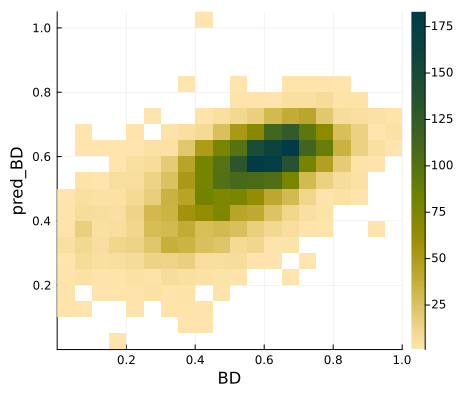

Plotting SOCconc: valid points = 56117


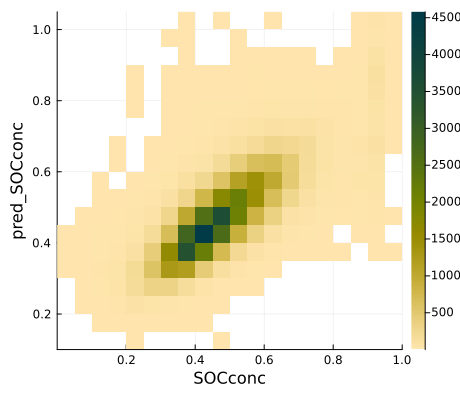

Plotting CF: valid points = 5194


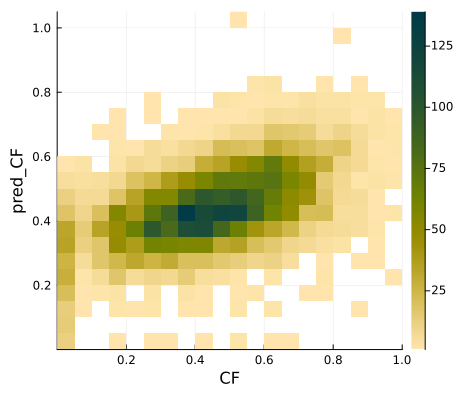

Plotting SOCdensity: valid points = 5194


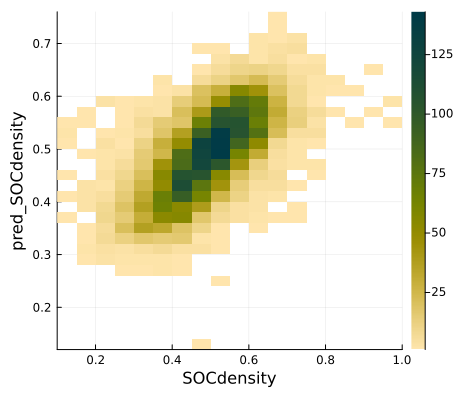

In [4]:
for tgt in ["BD", "SOCconc", "CF", "SOCdensity"]

    true_vals = rlt_pred[:, Symbol(tgt)]
    pred_vals = rlt_pred[:, Symbol("pred_", tgt)]

    # 过滤掉 invalid 值（避免 NaN 出图报错）
    mask = map(!isnan, true_vals) .& map(!isnan, pred_vals)
    x = true_vals[mask]
    y = pred_vals[mask]

    println("Plotting $tgt: valid points = ", length(x))

    plt = histogram2d(
        x, y;
        nbins = (30, 30),
        cbar = true,
        xlab = tgt,
        ylab = "pred_$tgt",
        color = cgrad(:bamako, rev=true),
        normalize = false,
        size = (460, 400),
    )

    display(plt)
end


Variable: pred_BD
  Valid count = 56117
  Min = 0.0
  Max = 1.0



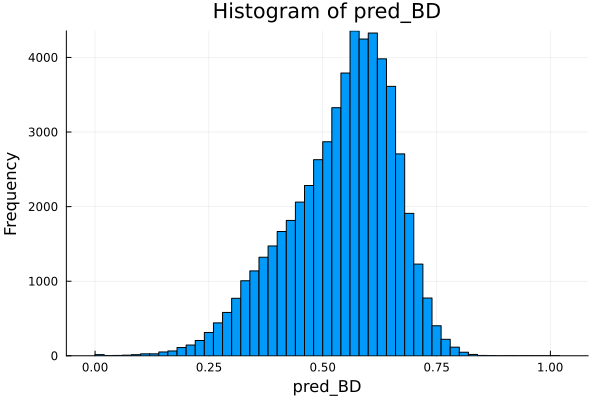

Variable: pred_SOCconc
  Valid count = 56117
  Min = 0.1237863302230835
  Max = 1.0



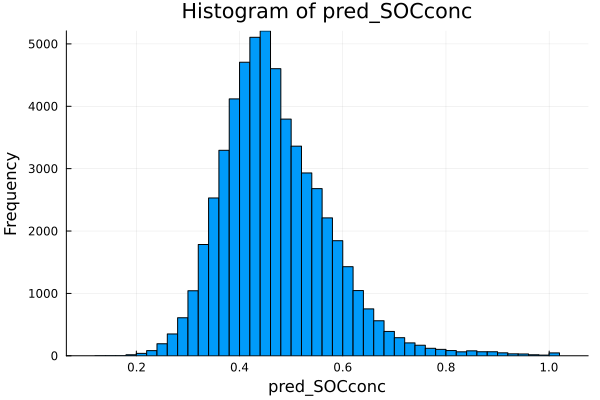

Variable: pred_CF
  Valid count = 56117
  Min = 0.0
  Max = 1.0



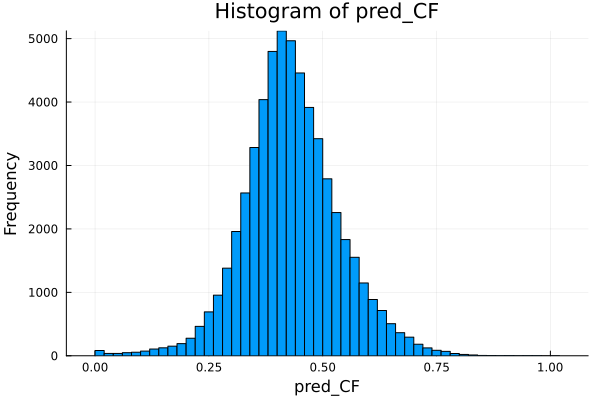

Variable: pred_SOCdensity
  Valid count = 56117
  Min = 0.0
  Max = 0.8630749464035035



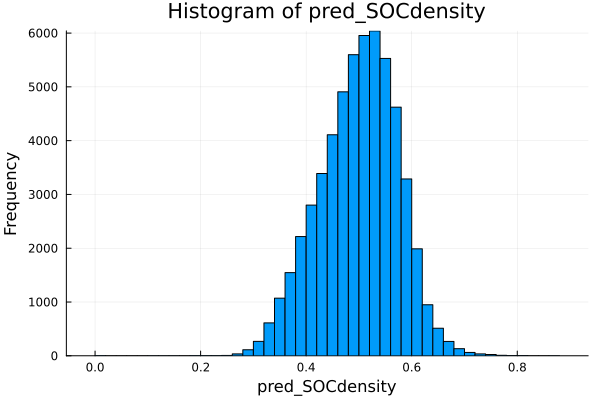

In [5]:
for col in ["pred_BD", "pred_SOCconc", "pred_CF", "pred_SOCdensity"]

    vals = rlt_pred[:, col]

    # 有效值（非 missing 且非 NaN）
    valid_vals = filter(x -> !ismissing(x) && !isnan(x), vals)

    n_valid = length(valid_vals)
    vmin = minimum(valid_vals)
    vmax = maximum(valid_vals)

    println("Variable: $col")
    println("  Valid count = $n_valid")
    println("  Min = $vmin")
    println("  Max = $vmax\n")

    histogram(
        vals;
        bins = 50,
        xlabel = col,
        ylabel = "Frequency",
        title = "Histogram of $col",
        lw = 1,
        legend = false
    )
    display(current())
end


In [6]:
println(size(rlt_pred))

(56117, 389)
